In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sipm.recon.WaveformAnalyzer as wfa
import sipm.recon.WaveformDataset as wfd
from scipy.optimize import curve_fit
import ROOT
import sipm.util.functions as func
import pandas as pd
import glob

Welcome to JupyROOT 6.26/06


In [2]:
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
!pwd

/home/as111/sipm-analysis


## Example waveforms

/scratch/gpfs/GALBIATI/data/sipm/reflector_studies//2022-11-22/2022-11-22_volt_65_pos_bottom_light_laser_coinc_laser_cond_calibration/0/wave0.dat


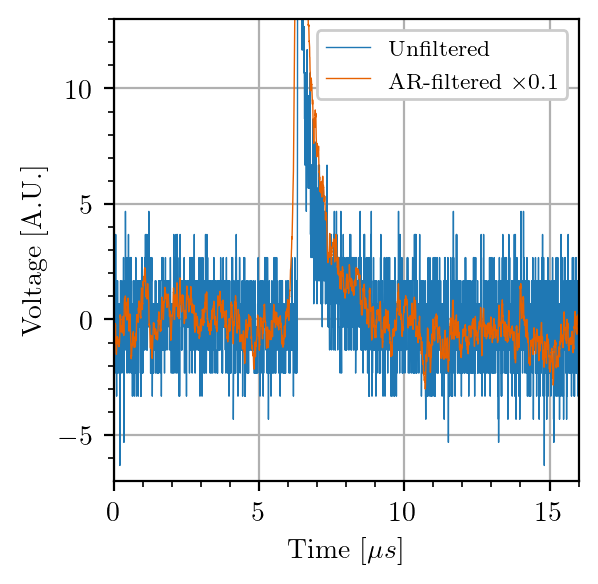

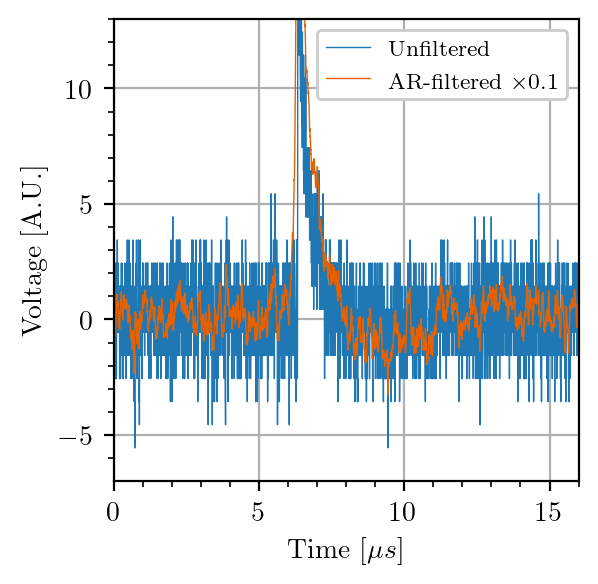

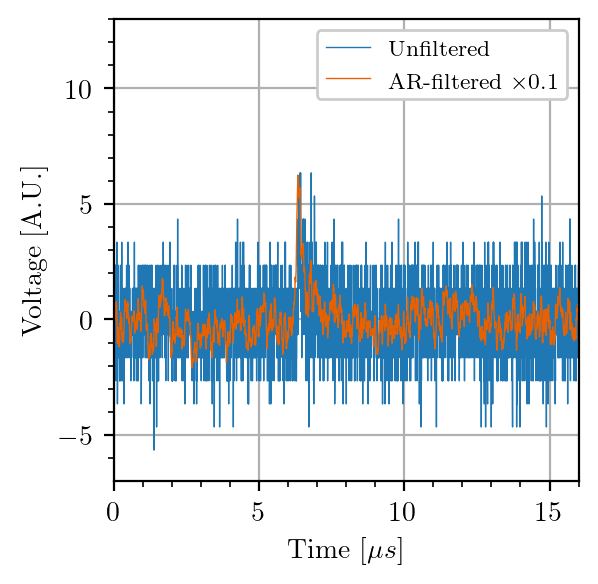

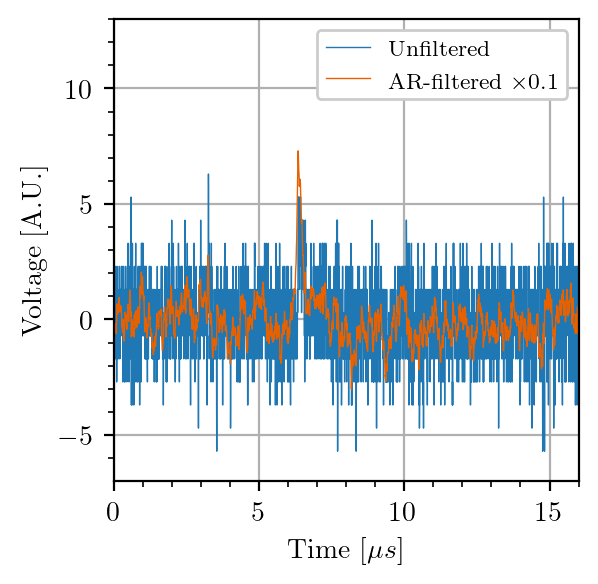

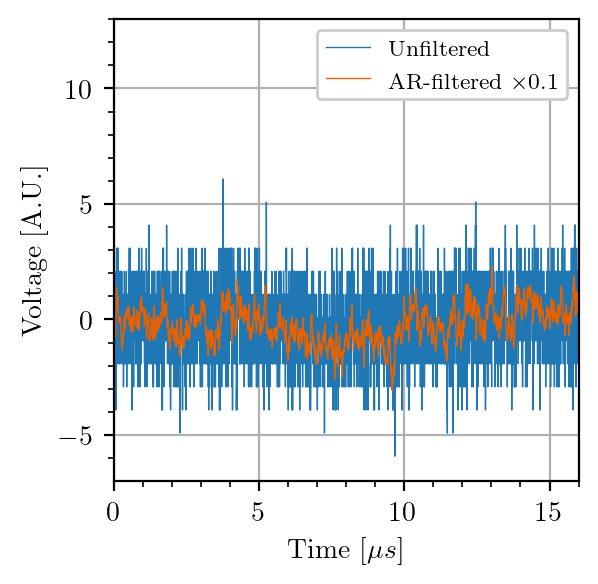

In [4]:
data_dir = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/'
direc = '2022-11-22/2022-11-22_volt_65_pos_bottom_light_laser_coinc_laser_cond_calibration/0/'
ch = 0
evid = np.arange(5,10)
dset = wfd.WaveformDataset(path='{}{}'.format(data_dir,direc), pol=-1, channels=range(4))
wfs, arwfs = dset.ch[ch].get_waveforms(ev=evid, ar_filter=True)

for i,wf in enumerate(wfs):
    plt.figure(i,figsize=(3,3))
    plt.plot(dset.ch[ch].time, wf, label='Unfiltered', linewidth=0.5)
    plt.plot(dset.ch[ch].time, arwfs[i]*0.1, label=r'AR-filtered $\times0.1$', linewidth=0.5)
    plt.legend(loc='upper right')
    plt.xlabel(r'Time [$\mu s$]')
    plt.ylabel(r'Voltage [A.U.]')
    plt.minorticks_on()
    plt.grid()
    plt.xlim(0,16)
    plt.ylim(-7,13)

# Load pre-processed h5 files

In [4]:
### data folder
path = "/scratch/gpfs/as111/results/2022-11-22/"
data = {}
for pos in ['top','bottom']:
    data[pos] = {}
    for ch in [0,1,2,3]:
        data[pos][ch] = {}
        for volt in [63,65,67,69,71]:
            data[pos][ch][volt] = []
            files = glob.glob(f"{path}/*volt_{volt}_pos_{pos}*.h5")
            for f in files:
                df = pd.read_hdf(f, key=f'{volt}/{ch}')
                data[pos][ch][volt].append(df)
            data[pos][ch][volt] = pd.concat(data[pos][ch][volt], ignore_index=True)
print('keys: ', data['top'][0][63].keys())

keys:  Index(['baseline_mean', 'baseline_rms', 'amplitude_trig', 'peakpos_trig',
       'integral_5p00us'],
      dtype='object')


## Playing with pandas dataframe
Baseline quality cut using pd.DataFrame

In [8]:
for pos in ['top','bottom']:
    for ch in [0,1,2,3]:
        for volt in [63,65,67,69,71]:
            df = pd.DataFrame(data[pos][ch][volt])
            df_cut = df[df['baseline_rms']<2.5]
            cut_fraction = 1-df_cut.shape[0]/df.shape[0]
            print(f'{pos} ch{ch} {volt}V cut fraction = {cut_fraction*100:.5f}%' )

top ch0 63V cut fraction = 0.04413%
top ch0 65V cut fraction = 0.06414%
top ch0 67V cut fraction = 0.08508%
top ch0 69V cut fraction = 0.11009%
top ch0 71V cut fraction = 0.13284%
top ch1 63V cut fraction = 0.06141%
top ch1 65V cut fraction = 0.08371%
top ch1 67V cut fraction = 0.10464%
top ch1 69V cut fraction = 0.12238%
top ch1 71V cut fraction = 0.13739%
top ch2 63V cut fraction = 0.04731%
top ch2 65V cut fraction = 0.07279%
top ch2 67V cut fraction = 0.09099%
top ch2 69V cut fraction = 0.10463%
top ch2 71V cut fraction = 0.12147%
top ch3 63V cut fraction = 0.03366%
top ch3 65V cut fraction = 0.06051%
top ch3 67V cut fraction = 0.07097%
top ch3 69V cut fraction = 0.09599%
top ch3 71V cut fraction = 0.11510%
bottom ch0 63V cut fraction = 0.19152%
bottom ch0 65V cut fraction = 0.20882%
bottom ch0 67V cut fraction = 0.22793%
bottom ch0 69V cut fraction = 0.32163%
bottom ch0 71V cut fraction = 0.44404%
bottom ch1 63V cut fraction = 2.68219%
bottom ch1 65V cut fraction = 1.62276%
bottom 

Plots for top ch0 63V


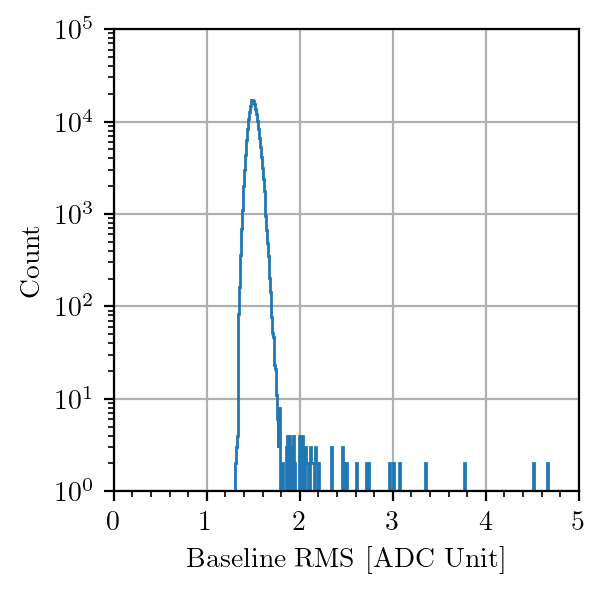

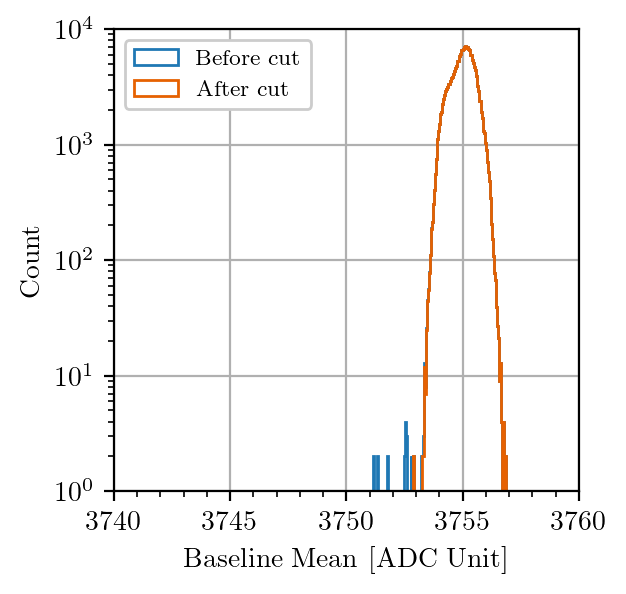

In [10]:
pos = 'top'
ch = 0
volt = 63
print(f'Plots for {pos} ch{ch} {volt}V')
df = pd.DataFrame(data[pos][ch][volt])
df_cut = df[df['baseline_rms']<2.5]

nbins = 500
range_min = 0
range_max = 5
bin_width = (range_max-range_min)/nbins
plt.figure(0,figsize=(3,3))
plt.hist(df['baseline_rms'], bins=np.linspace(range_min, range_max, nbins+1), histtype='step')
plt.yscale('log')
plt.xlabel('Baseline RMS [ADC Unit]')
plt.ylabel('Count')
plt.minorticks_on()
plt.grid()

nbins = 500
range_min = 3740
range_max = 3760
bin_width = (range_max-range_min)/nbins
plt.figure(1,figsize=(3,3))
plt.hist(df['baseline_mean'], label='Before cut', bins=np.linspace(range_min, range_max, nbins+1), histtype='step')
plt.hist(df_cut['baseline_mean'], label='After cut', bins=np.linspace(range_min, range_max, nbins+1), histtype='step')
plt.legend()
plt.yscale('log')
plt.xlabel('Baseline Mean [ADC Unit]')
plt.ylabel('Count')
plt.minorticks_on()
plt.grid()


# Top tile calibration (1122 data)

## Load data

In [18]:
bias = [63, 65, 67, 69, 71]
ds1122top = []
for i,volt in enumerate(bias):
    dset = wfd.WaveformDataset(path='', channels=range(4))
    file = ROOT.TFile("/scratch/gpfs/as111/root/calibration_1122_{}V_top.root".format(volt), "read")
    tree = file.Get("tree")
    nev = 0
    nev_cut = [0,0,0,0]
    for ch in dset.ch:
        ch.baseline_avg = []
        ch.baseline_std = []
        ch.famp = []
        ch.integral_long = []
    for iev,ev in enumerate(tree):
        nev += 1
        for ich,ch in enumerate(dset.ch):
            ch.baseline_avg.append(ev.bsl_avg[ich])
            ch.baseline_std.append(ev.bsl_std[ich])
            if(ev.bsl_std[ich]<2.5):
                ch.famp.append(ev.fil_amp[ich])
                ch.integral_long.append(ev.int_long[ich])
                nev_cut[ich] += 1
    file.Close()
    print('top {}V {} events loaded.'.format(volt, nev))
    for ich,ch in enumerate(dset.ch):
        ch.cumulative_nevents = nev
        ch.nevents_aftercut = nev_cut[ich]
        print('Ch{} cut fraction={:.3f}%'.format(ich, 100*(1-nev_cut[ich]/nev)))
    ds1122top.append(dset)

top 63V 219823 events loaded.
Ch0 cut fraction=0.044%
Ch1 cut fraction=0.061%
Ch2 cut fraction=0.047%
Ch3 cut fraction=0.034%
top 65V 219816 events loaded.
Ch0 cut fraction=0.064%
Ch1 cut fraction=0.084%
Ch2 cut fraction=0.073%
Ch3 cut fraction=0.061%
top 67V 219803 events loaded.
Ch0 cut fraction=0.085%
Ch1 cut fraction=0.105%
Ch2 cut fraction=0.091%
Ch3 cut fraction=0.071%
top 69V 219813 events loaded.
Ch0 cut fraction=0.110%
Ch1 cut fraction=0.122%
Ch2 cut fraction=0.105%
Ch3 cut fraction=0.096%
top 71V 219812 events loaded.
Ch0 cut fraction=0.133%
Ch1 cut fraction=0.137%
Ch2 cut fraction=0.121%
Ch3 cut fraction=0.115%


## Baseline cut
To avoid pre-trigger pulses or abnormal fluctuations, we require that the standard deviation in the baseline region ($t<t_{\rm trigger}-0.5~\rm\mu s$) be less than $2.5$ ADC units.
This baseline cut normalizes the baseline mean distribution.
Cut fraction is around $0.1\%$ for the top tile.
Same cut also applies to the scintillation waveforms.

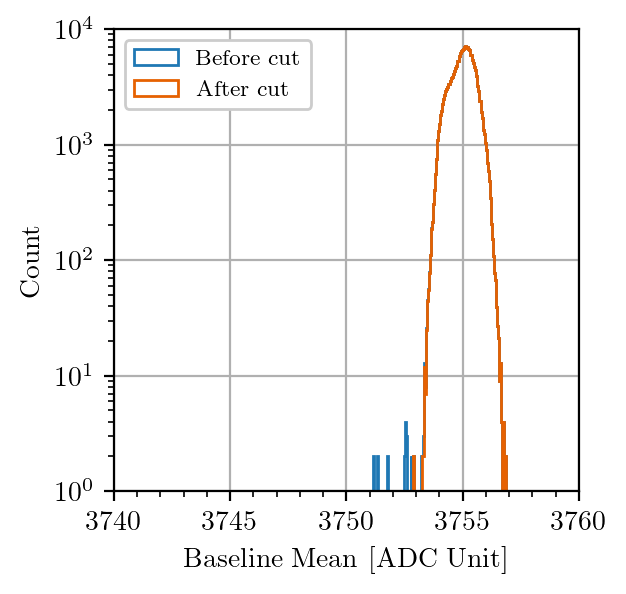

In [19]:
i=0
ch=0
dset = ds1122top[i].ch[ch]

nbins = 500
range_min = 3740
range_max = 3760
bin_width = (range_max-range_min)/nbins

bsl_avg_cut = []
for ev,avg in enumerate(dset.baseline_avg):
    if dset.baseline_std[ev]<2.5:
        bsl_avg_cut.append(avg)

plt.figure(0,figsize=(3,3))
plt.hist(dset.baseline_avg, label='Before cut', bins=np.linspace(range_min, range_max, nbins+1), histtype='step')
plt.hist(bsl_avg_cut, label='After cut', bins=np.linspace(range_min, range_max, nbins+1), histtype='step')
plt.legend()
plt.yscale('log')
plt.xlabel('Baseline Mean [ADC Unit]')
plt.ylabel('Count')
plt.minorticks_on()
plt.grid()

## Filtered amplitude and direct crosstalk (DiCT)
Here is the analysis with the prompt amplitude of AR-filtered waveforms.
The PE peak positions are identified with scipy package.
Let $A_k$ be the peak position of the $k$-PE peak (including $k=0$).
$(A_{k-1}+A_{k})/2$ is defined as the boundary between $k-1$ PEs and $k$ PEs.
The lower boundary of the 0th PE is $A_0 - 0.5(A_1-A_0)$ and similarly for the upper boundary of the highest identifiable PE.
The vertical dashed lines in the finger plots represent the boundaries.<br>

Let $P_k$ be the fraction of events within the $k$-PE boundaries, that is, the probability distribution of PE count $k$.
It can be fitted by the [compound Poisson distribution](https://ieeexplore.ieee.org/document/5402300) describing a binomial chain process (with parameter $p$ called the DiCT probability) with Poisson-distributed primary photoelectrons (with parameter $\mu$ equal to average incident photons times PDE).
The expected value is $\rm{E}[k]=\frac{\mu}{1-p}$ and the variance is $\rm{Var}[k]=\frac{\mu(1+p)}{(1-p)^2}$.


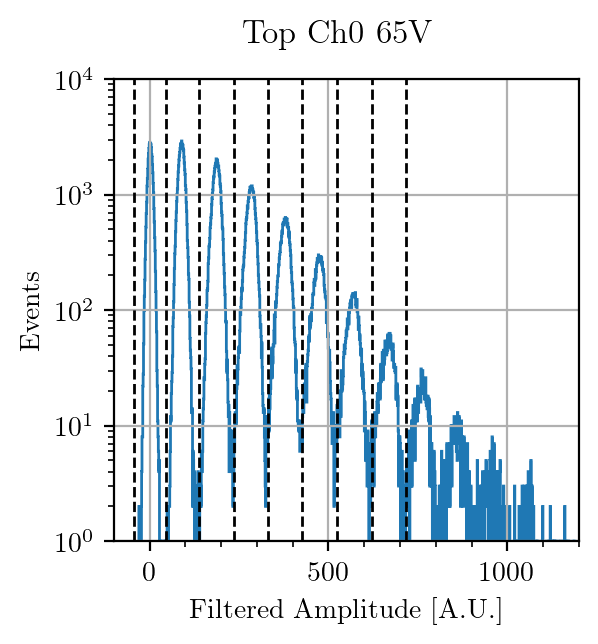

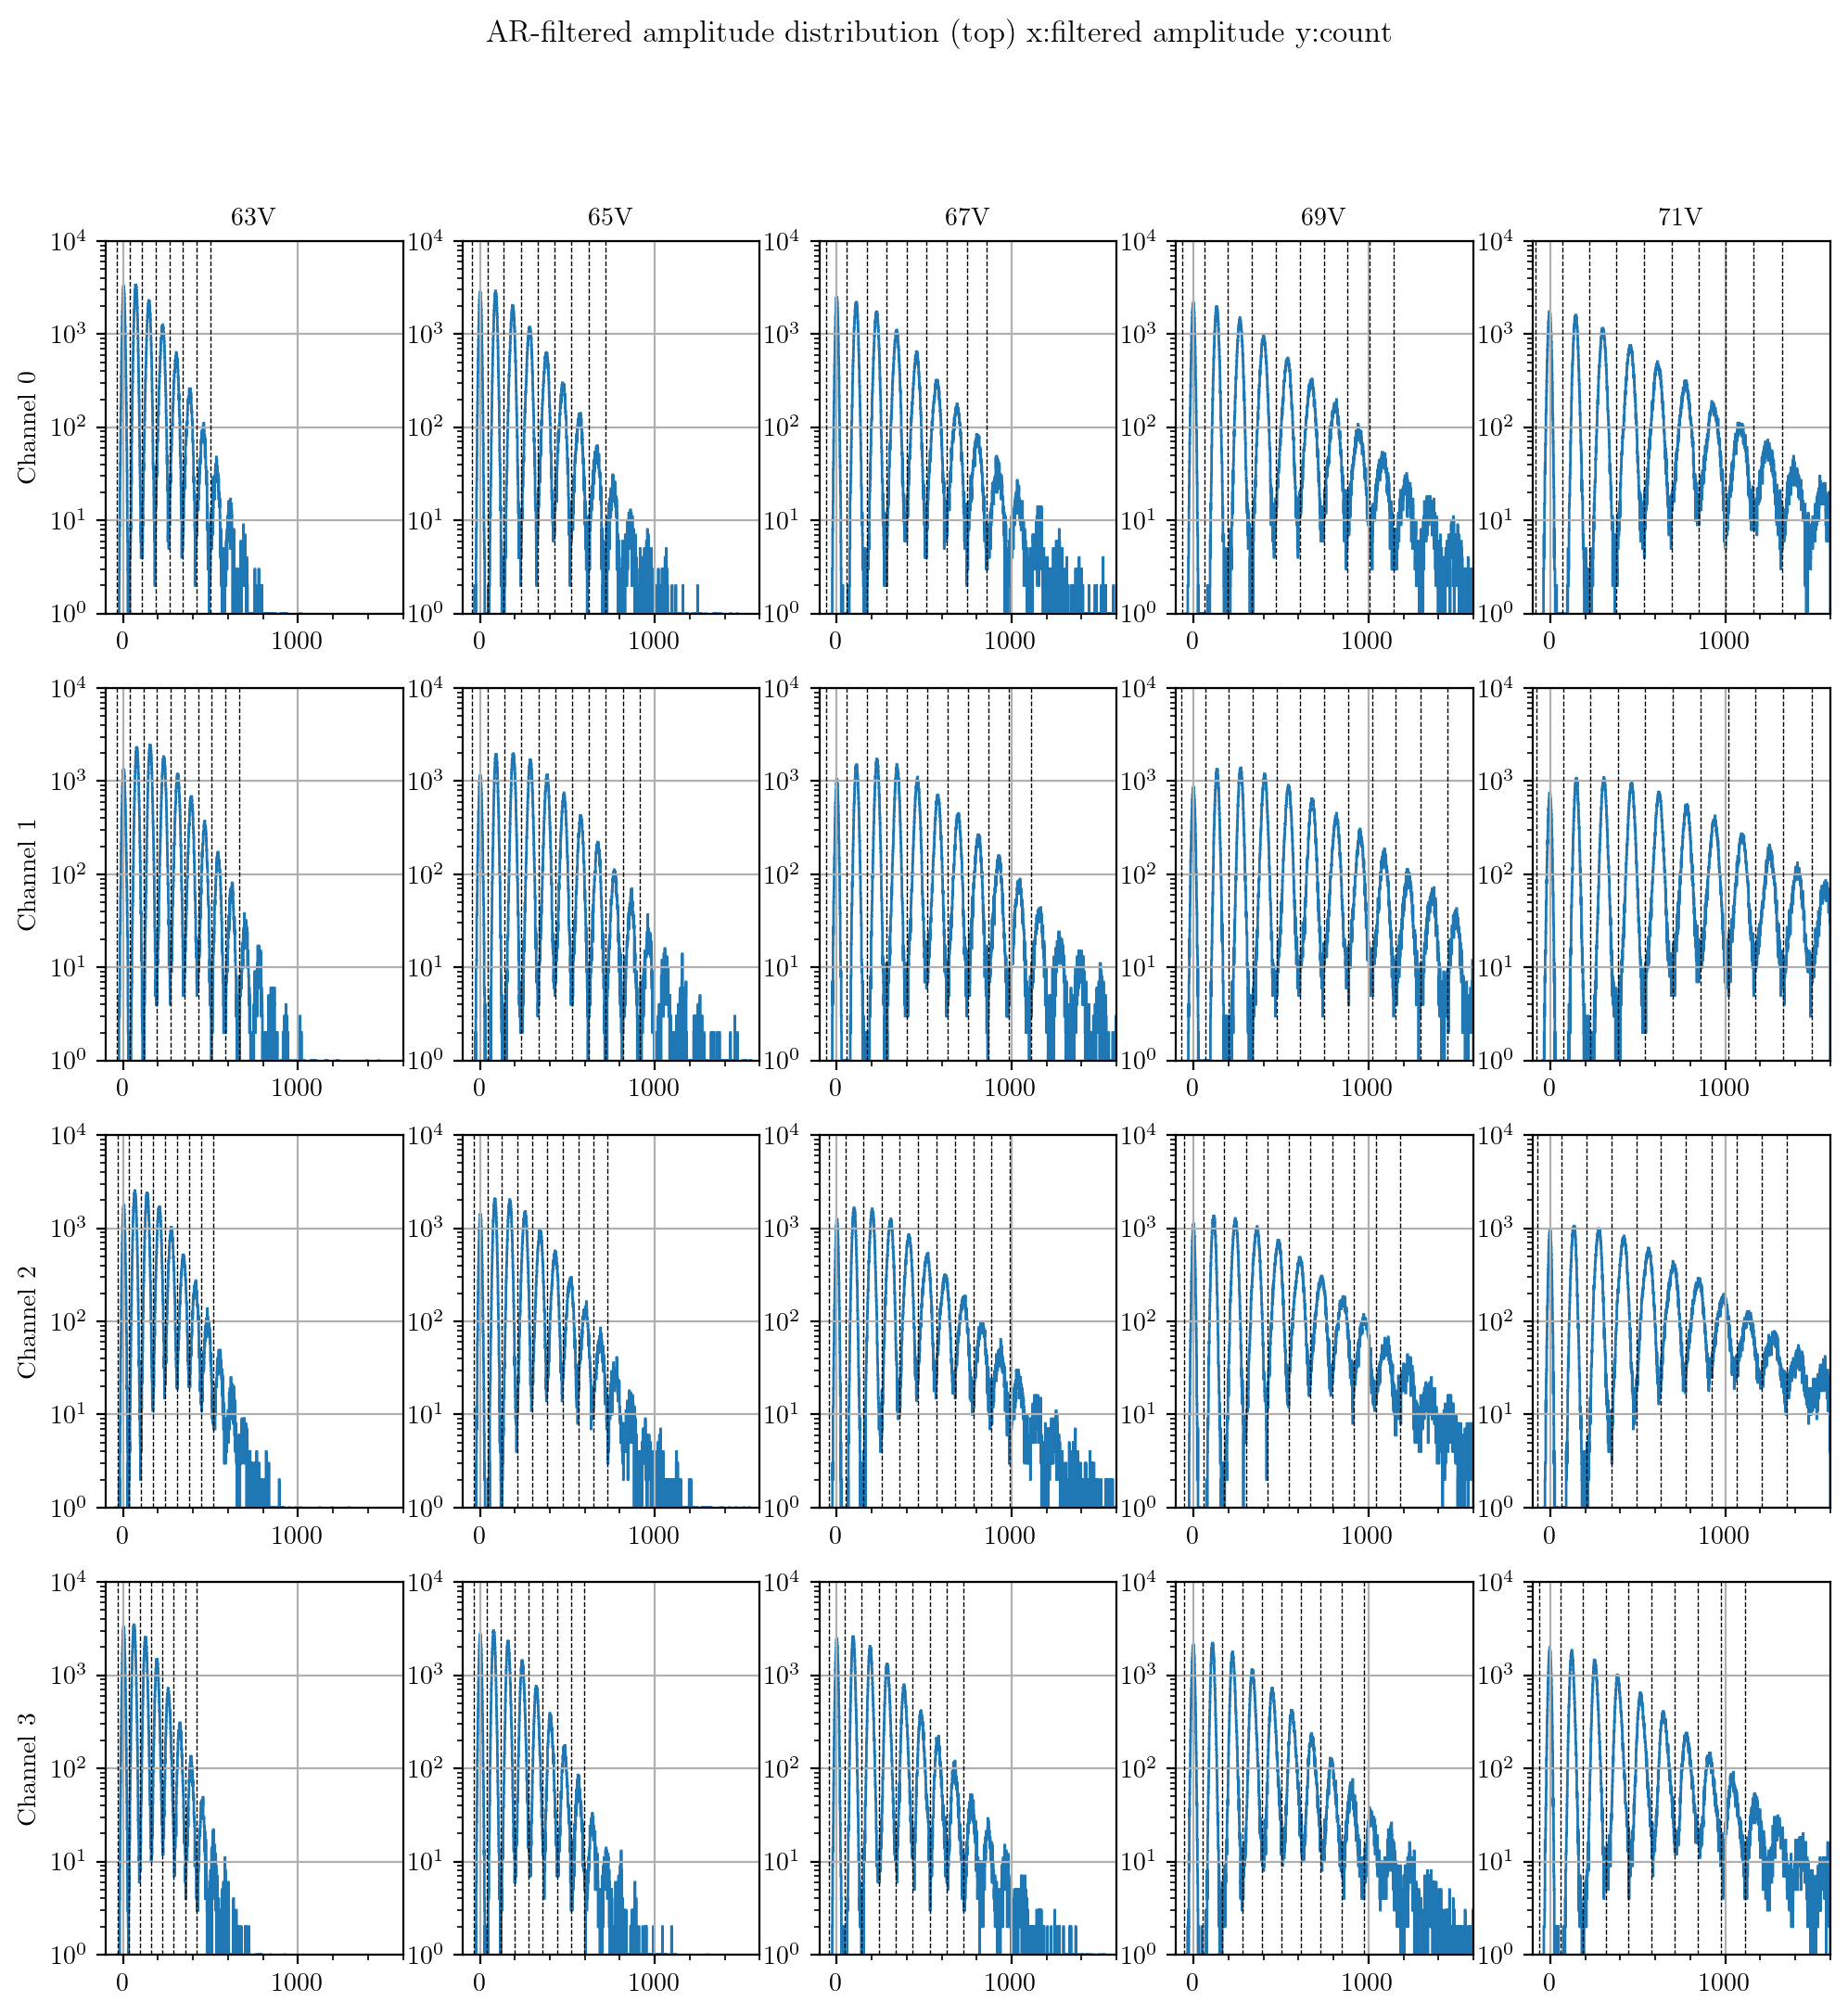

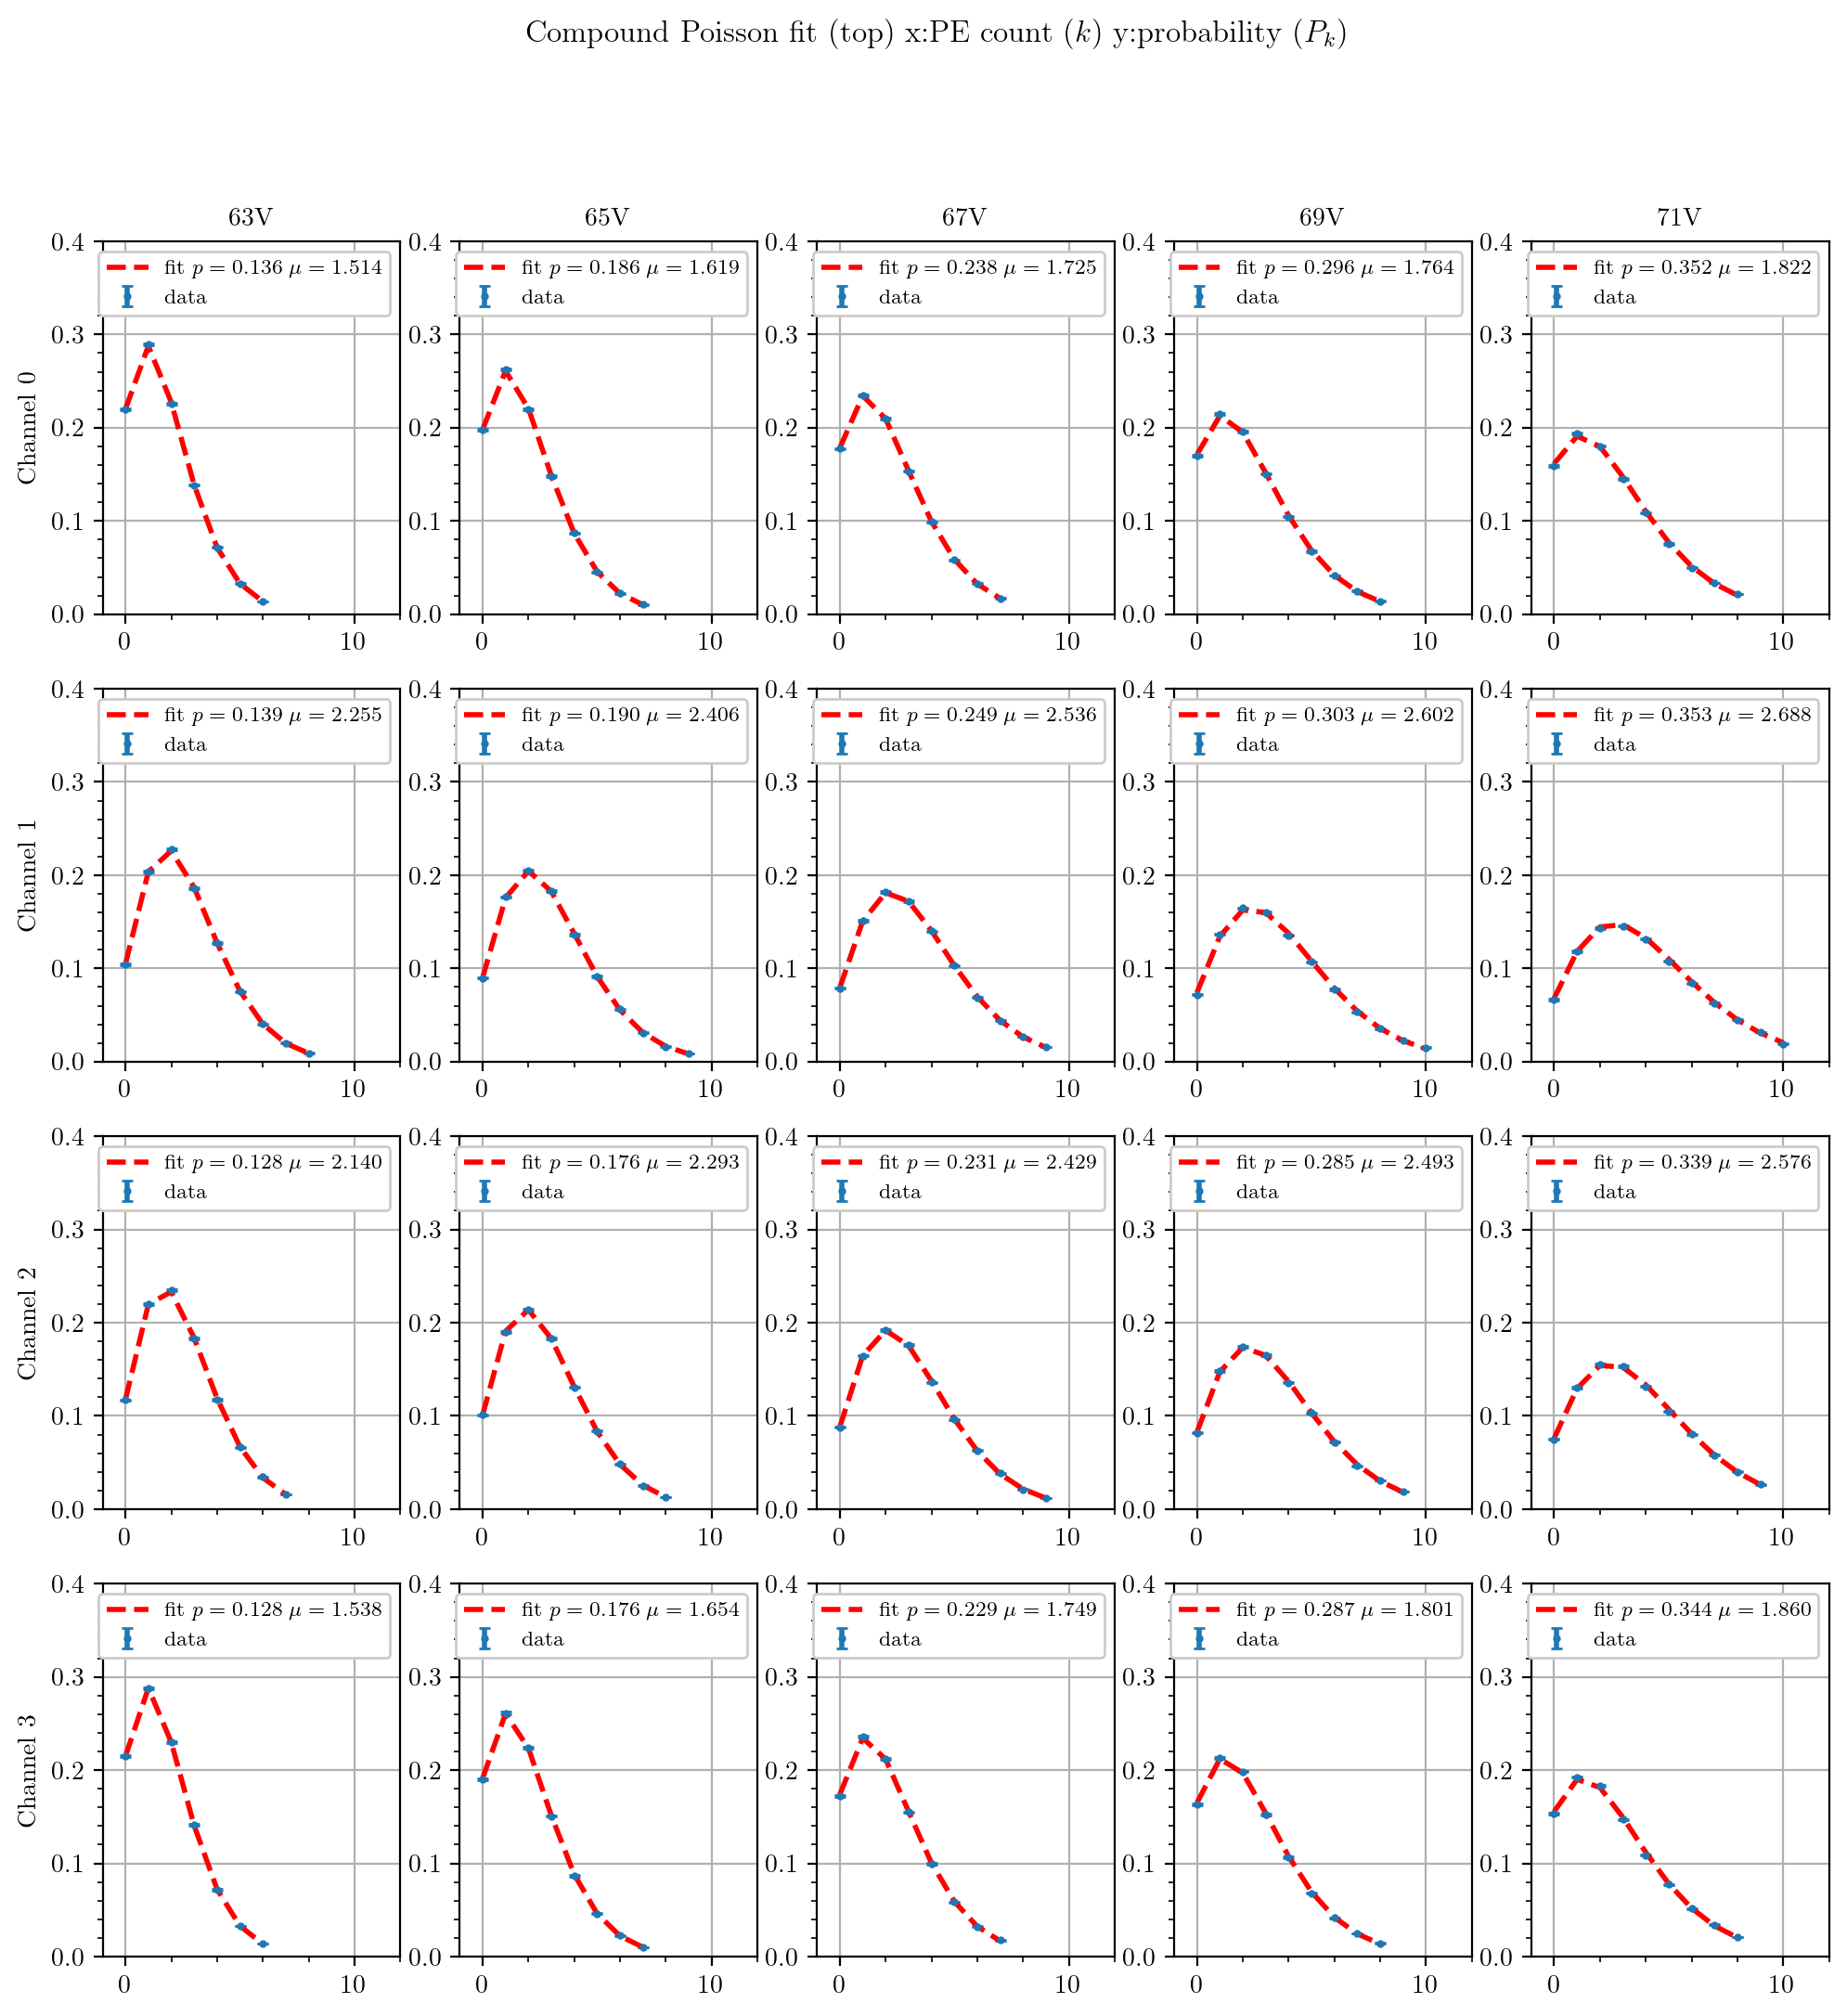

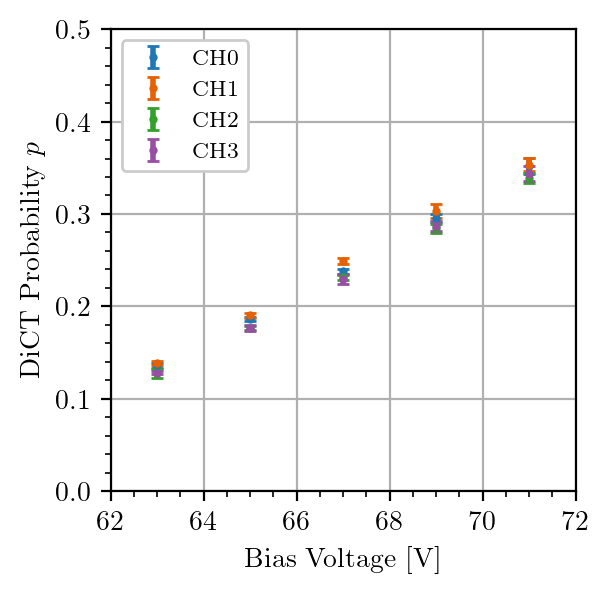

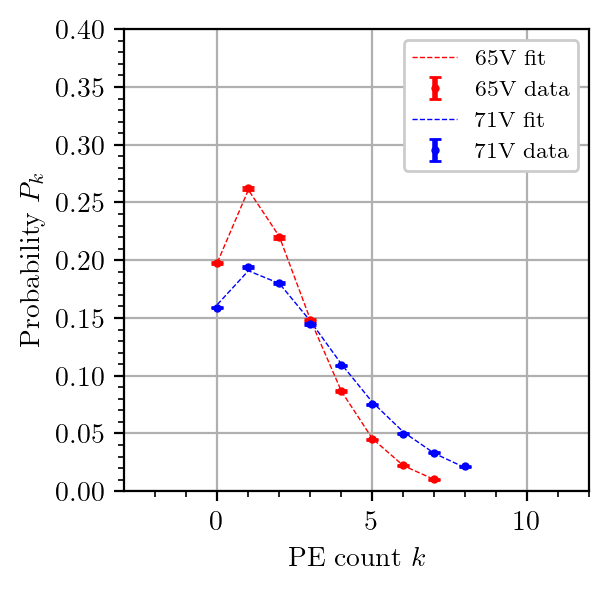

In [7]:
plt.figure(0,figsize=(12,12)) # for filtered amplitude histograms
plt.suptitle(r'AR-filtered amplitude distribution (top) x:filtered amplitude y:count')
plt.figure(1,figsize=(12,12)) # for Vinogradov fit
plt.suptitle(r'Compound Poisson fit (top) x:PE count ($k$) y:probability ($P_k$)')
plt.figure(2,figsize=(3,3)) # for crosstalk summary
plt.figure(3,figsize=(3,3)) # finger plot for a particular channel
plt.figure(4,figsize=(3,3)) # dict fit for a particular channel

# choice of channel and voltage for finger plot
chn = 0
iv = 1
# additional choice of voltage for vinogradov fit
ivv = 4

# finger plot binning
nbins = 1600
range_min = -1e2
range_max = 1.6e3
bin_width = (range_max-range_min)/nbins

for ch in range(4):
    for i,data in enumerate(ds1122top):  
        # filtered amplitude histogram
        data.ch[ch].get_famp_hist(bin=[range_min,range_max,nbins])
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.stairs(data.ch[ch].famp_hist, data.ch[ch].famp_hist_bin)
        plt.yscale('log')
        plt.xlim(data.ch[ch].famp_hist_bin[0], data.ch[ch].famp_hist_bin[-1])
        plt.ylim(1, 1e4)
        plt.minorticks_on()
        plt.grid()      
        # find PE peaks in histograms
        data.ch[ch].find_histo_peaks(thre=0, prom=50, wid=10, dist=8)
        # discriminate different PE counts and calculate probability distribution P_k
        P_k = []
        npe = len(data.ch[ch].peaks)
        pe_cuts_in_bins = []
        for ipe in range(npe+1):
            if ipe==0:
                pe_cuts_in_bins.append(int(1.5*data.ch[ch].peaks[0]-0.5*data.ch[ch].peaks[1]))
            elif ipe==npe:
                pe_cuts_in_bins.append(int(1.5*data.ch[ch].peaks[-1]-0.5*data.ch[ch].peaks[-2]))
            else:
                pe_cuts_in_bins.append(int(0.5*(data.ch[ch].peaks[ipe]+data.ch[ch].peaks[ipe-1])))
            plt.plot([pe_cuts_in_bins[ipe]*bin_width+range_min, pe_cuts_in_bins[ipe]*bin_width+range_min], [1,1e4], 'k--', linewidth=0.5)
            if ipe>0:
                P_k.append([np.sum(data.ch[ch].famp_hist[pe_cuts_in_bins[ipe-1]:pe_cuts_in_bins[ipe]])/data.ch[ch].nevents_aftercut, np.sqrt(np.sum(data.ch[ch].famp_hist[pe_cuts_in_bins[ipe-1]:pe_cuts_in_bins[ipe]]))/data.ch[ch].nevents_aftercut])
        data.ch[ch].pe_cuts = np.array(pe_cuts_in_bins)*bin_width+range_min
        # finger plot for the choice of channel and voltage
        if ch==chn and i==iv:
            plt.figure(3)
            plt.stairs(data.ch[ch].famp_hist, data.ch[ch].famp_hist_bin)
            plt.yscale('log')
            for pe_cut in data.ch[ch].pe_cuts:
                plt.plot([pe_cut, pe_cut], [1,1e4], 'k--', linewidth=1)
            plt.xlabel('Filtered Amplitude [A.U.]')
            plt.ylabel('Events')
            plt.suptitle('Top Ch{} {}V'.format(ch, bias[i]))
            plt.xlim(data.ch[ch].famp_hist_bin[0], 1200)
            plt.ylim(1, 1e4)
            plt.grid()
            plt.minorticks_on()     
        # vinogradov fit and plot
        plt.figure(1)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.errorbar(np.arange(len(P_k)), np.array(P_k)[:,0], yerr=np.array(P_k)[:,1], fmt='o', markersize=2, label='data')
        popt,pcov = curve_fit(func.compound_poisson, list(np.arange(len(P_k))), np.array(P_k)[:,0], p0=[2, 0.2], sigma=np.array(P_k)[:,1], maxfev=10000)
        data.ch[ch].dict = [popt[1],func.error_distance(df=2,sigma=1)*np.sqrt(pcov[1,1])]
        plt.plot(np.arange(len(P_k)), func.compound_poisson(np.arange(len(P_k)),*popt), 'r--', label=r'fit $p={:.3f}$ $\mu={:.3f}$'.format(popt[1],popt[0]))
        plt.ylim(0,0.4)
        plt.xlim(-1,12)
        plt.legend(loc='upper right')
        plt.minorticks_on()
        plt.grid()
        # vinogradov plot for the choice of channel and voltages
        if ch==chn and (i==iv or i==ivv):
            plt.figure(4)
            if i==iv:
                color='r'
            else:
                color='b'
            plt.errorbar(np.arange(len(P_k)), np.array(P_k)[:,0], yerr=np.array(P_k)[:,1], fmt='{}o'.format(color), markersize=2, label='{}V data'.format(bias[i]))
            plt.plot(np.arange(len(P_k)), func.compound_poisson(np.arange(len(P_k)),*popt), '{}--'.format(color), label='{}V fit'.format(bias[i]), linewidth=0.5)
    # plot crosstalk vs bias
    plt.figure(2)
    plt.errorbar(bias, [data.ch[ch].dict[0] for data in ds1122top], yerr=[data.ch[ch].dict[1] for data in ds1122top], label='CH{}'.format(ch), fmt='o', markersize=2)

# adjust figures
plt.figure(2)
plt.legend()
plt.xlabel(r'Bias Voltage [V]')
plt.ylabel(r'DiCT Probability $p$')
plt.grid()
plt.minorticks_on()
plt.xlim(62,72)
plt.ylim(0, 0.5)

plt.figure(4)
plt.ylim(0,0.4)
plt.xlim(-3,12)
plt.xlabel(r'PE count $k$')
plt.ylabel(r'Probability $P_k$')
#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = [0,2,1,3]
#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='upper right')
plt.minorticks_on()
plt.grid()

## Afterpulsing
Here is the analysis with time integral of the unfiltered waveforms.
The integral window is $5~\rm\mu s$ post-trigger and $0.5~\rm \mu s$ pre-trigger.
The integrals are grouped by the PE counts $k$ defined with the filtered amplitude (see previous cell).
The integral distribution has a Gaussian left tail but a heavier right tail due to afterpulses.
The part of the histograms near the peak is fitted by a Gaussian PDF to find the peak position, denoted by $I_{k,\rm peak}$.
$I_{k,\rm peak}$ is linear with $k$, and the slope $Q_{\rm peak}$ is the SPE gain of the SiPMs in arbitrary units.<br>

The average of the histogram is denoted by $I_{k,\rm avg}$.
It is also linear with $k$, and the slope is denoted by $Q_{\rm avg}$.
$Q_{\rm avg}$ is essentially the afterpulse charge per PE in addition to the SPE gain $Q_{\rm peak}$.
So the average afterpulse charge per PE is defined as $Q_{\rm AP}=\frac{Q_{\rm avg}}{Q_{\rm peak}}-1$.<br>

The breakdown voltage is obtained by a linear fit to $Q_{\rm peak}$ as a function of bias $V$ using $Q_{\rm peak}=C(V-V_{\rm bd})$.
A comparison of breakdown voltage across channels is further down in the notebook.

Channel 0 Vbd=53.773+/-0.442V slope=48.791+/-1.603
Channel 1 Vbd=53.342+/-0.168V slope=46.890+/-0.603
Channel 2 Vbd=53.733+/-0.263V slope=47.440+/-1.134
Channel 3 Vbd=53.027+/-0.709V slope=44.376+/-2.078


Text(0.5, 0.98, 'Afterpulse probability x:PE count $k$ y:$1-P_{\\rm AP}(k)$')

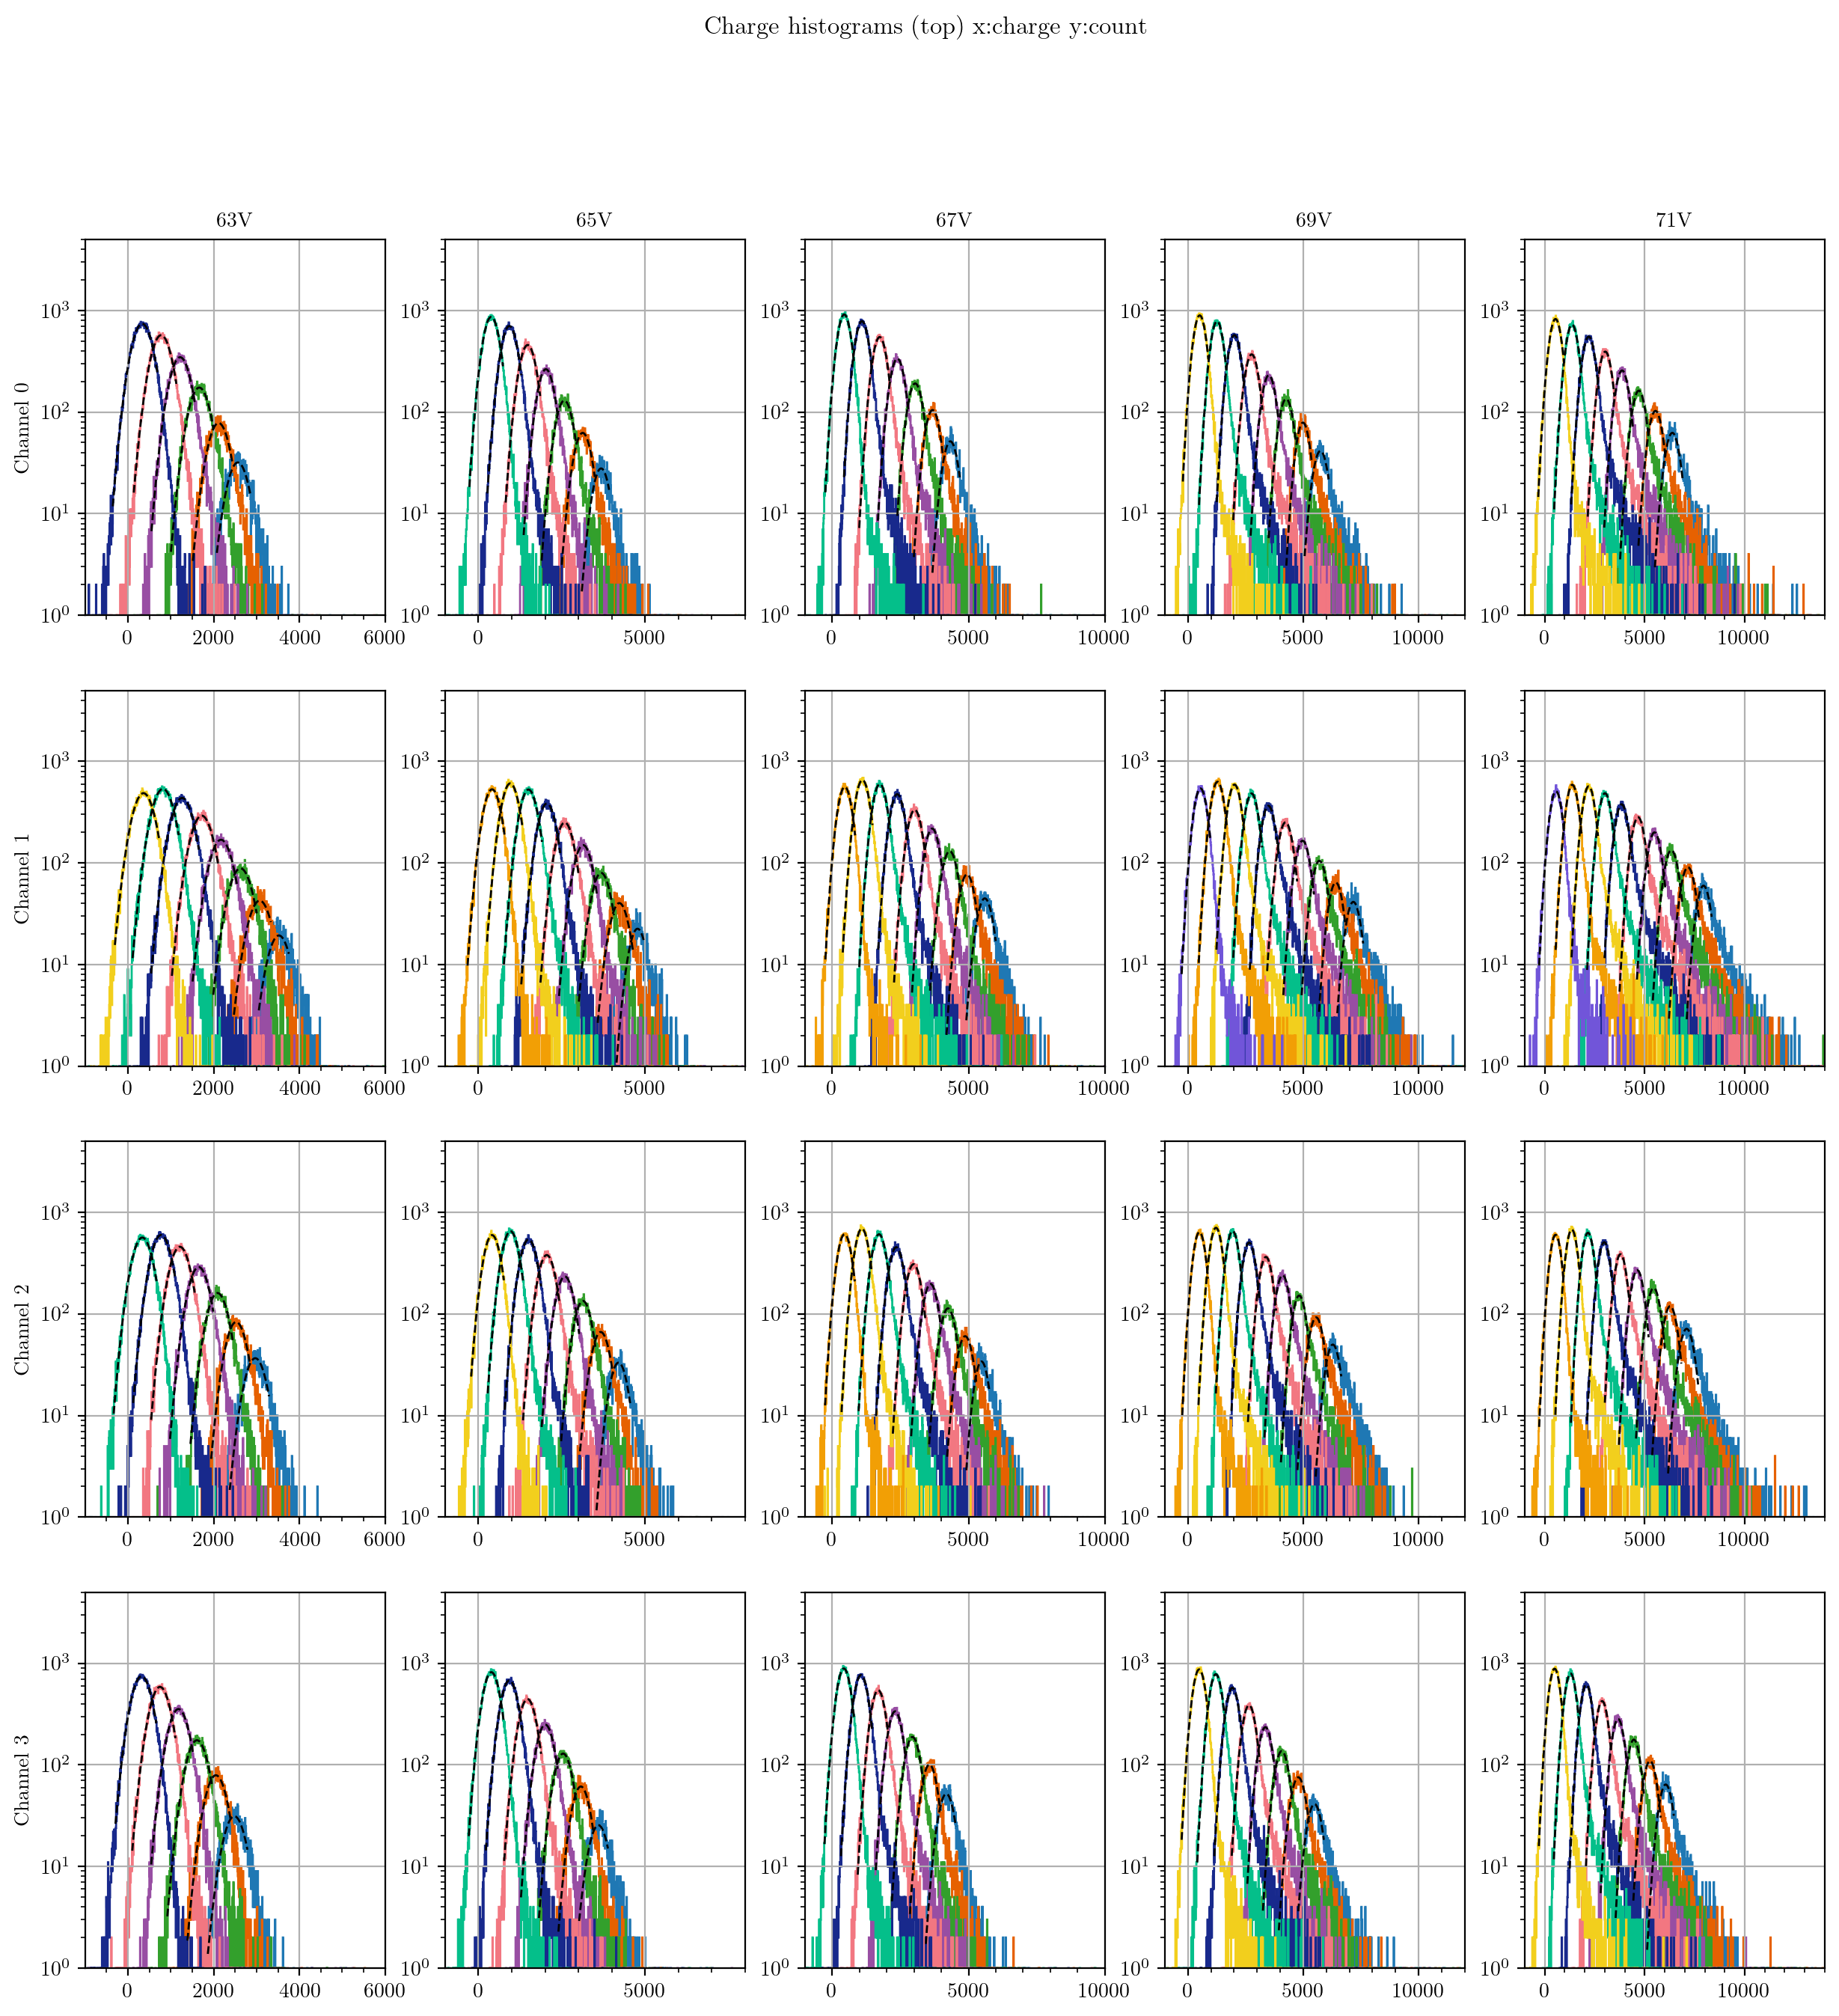

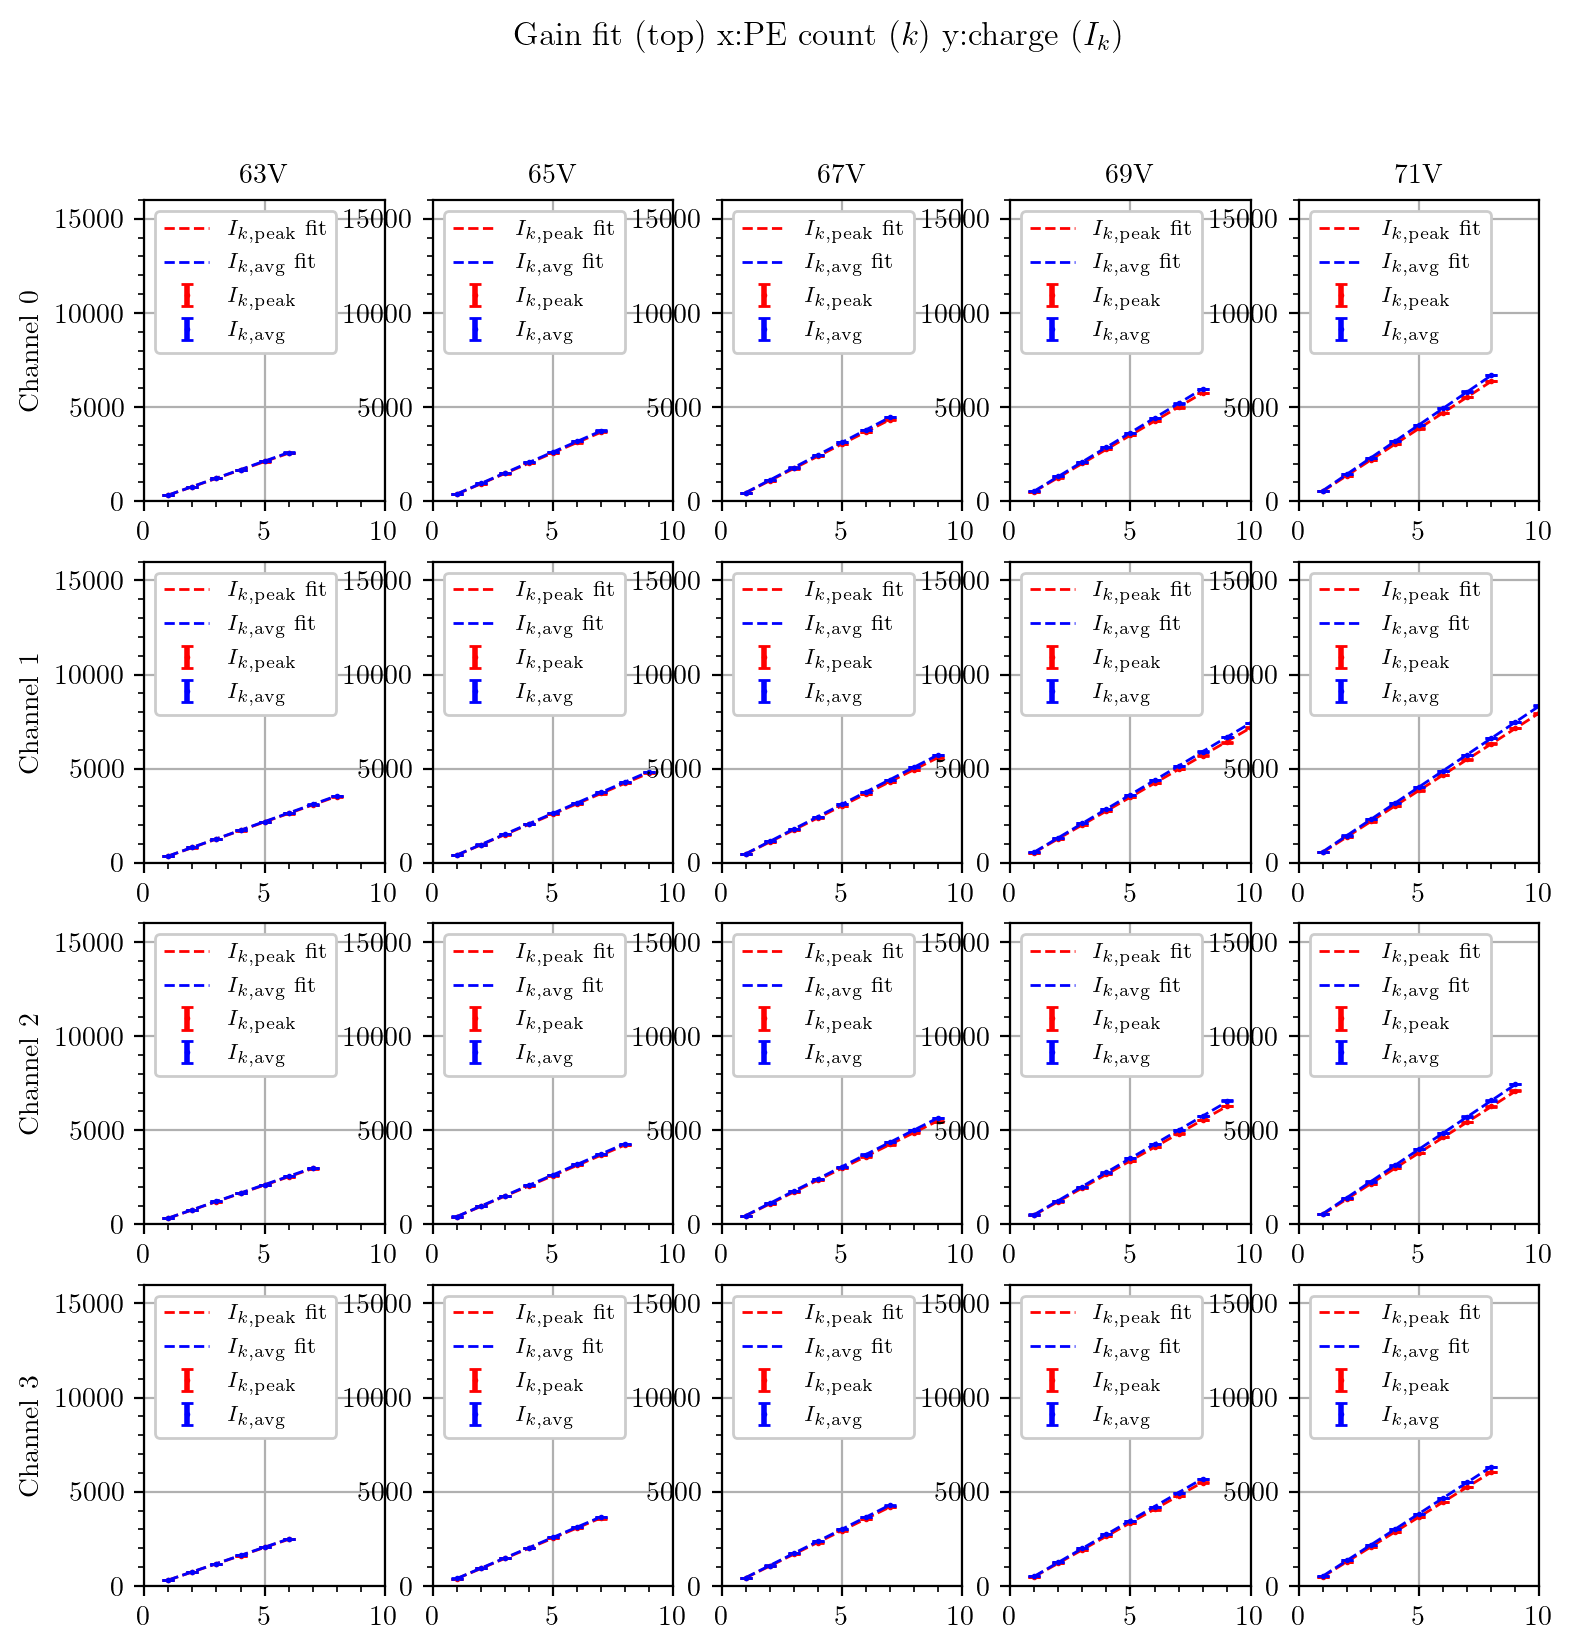

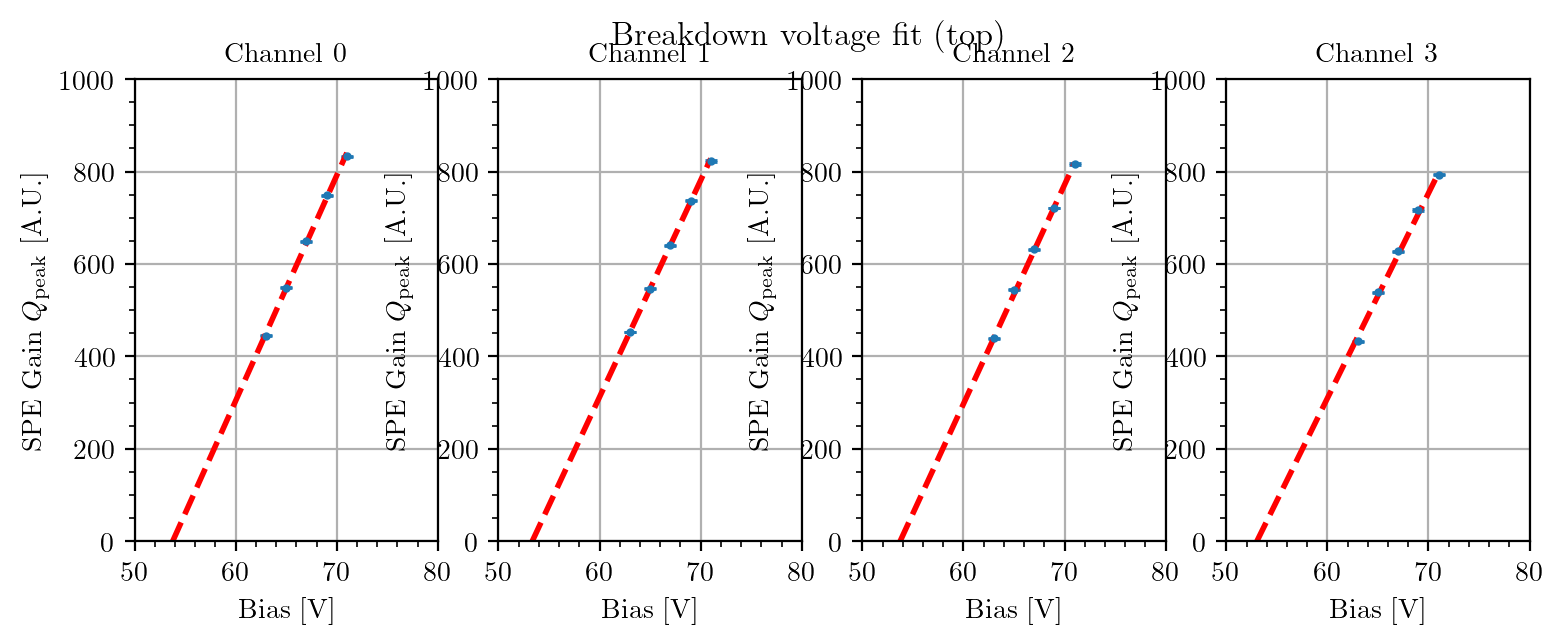

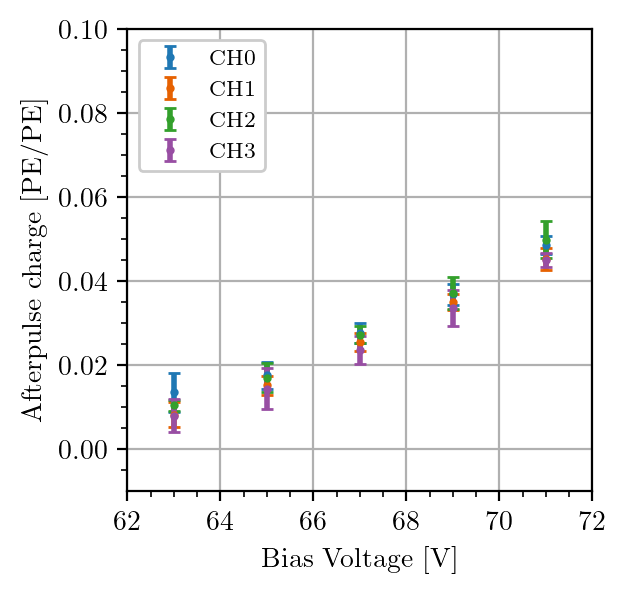

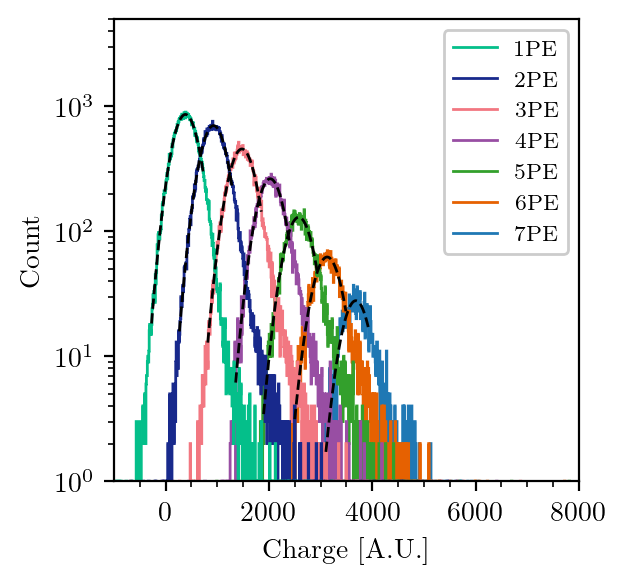

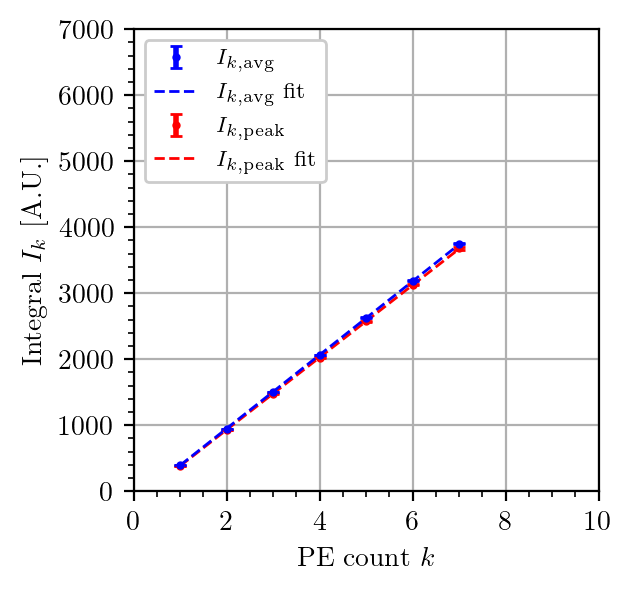

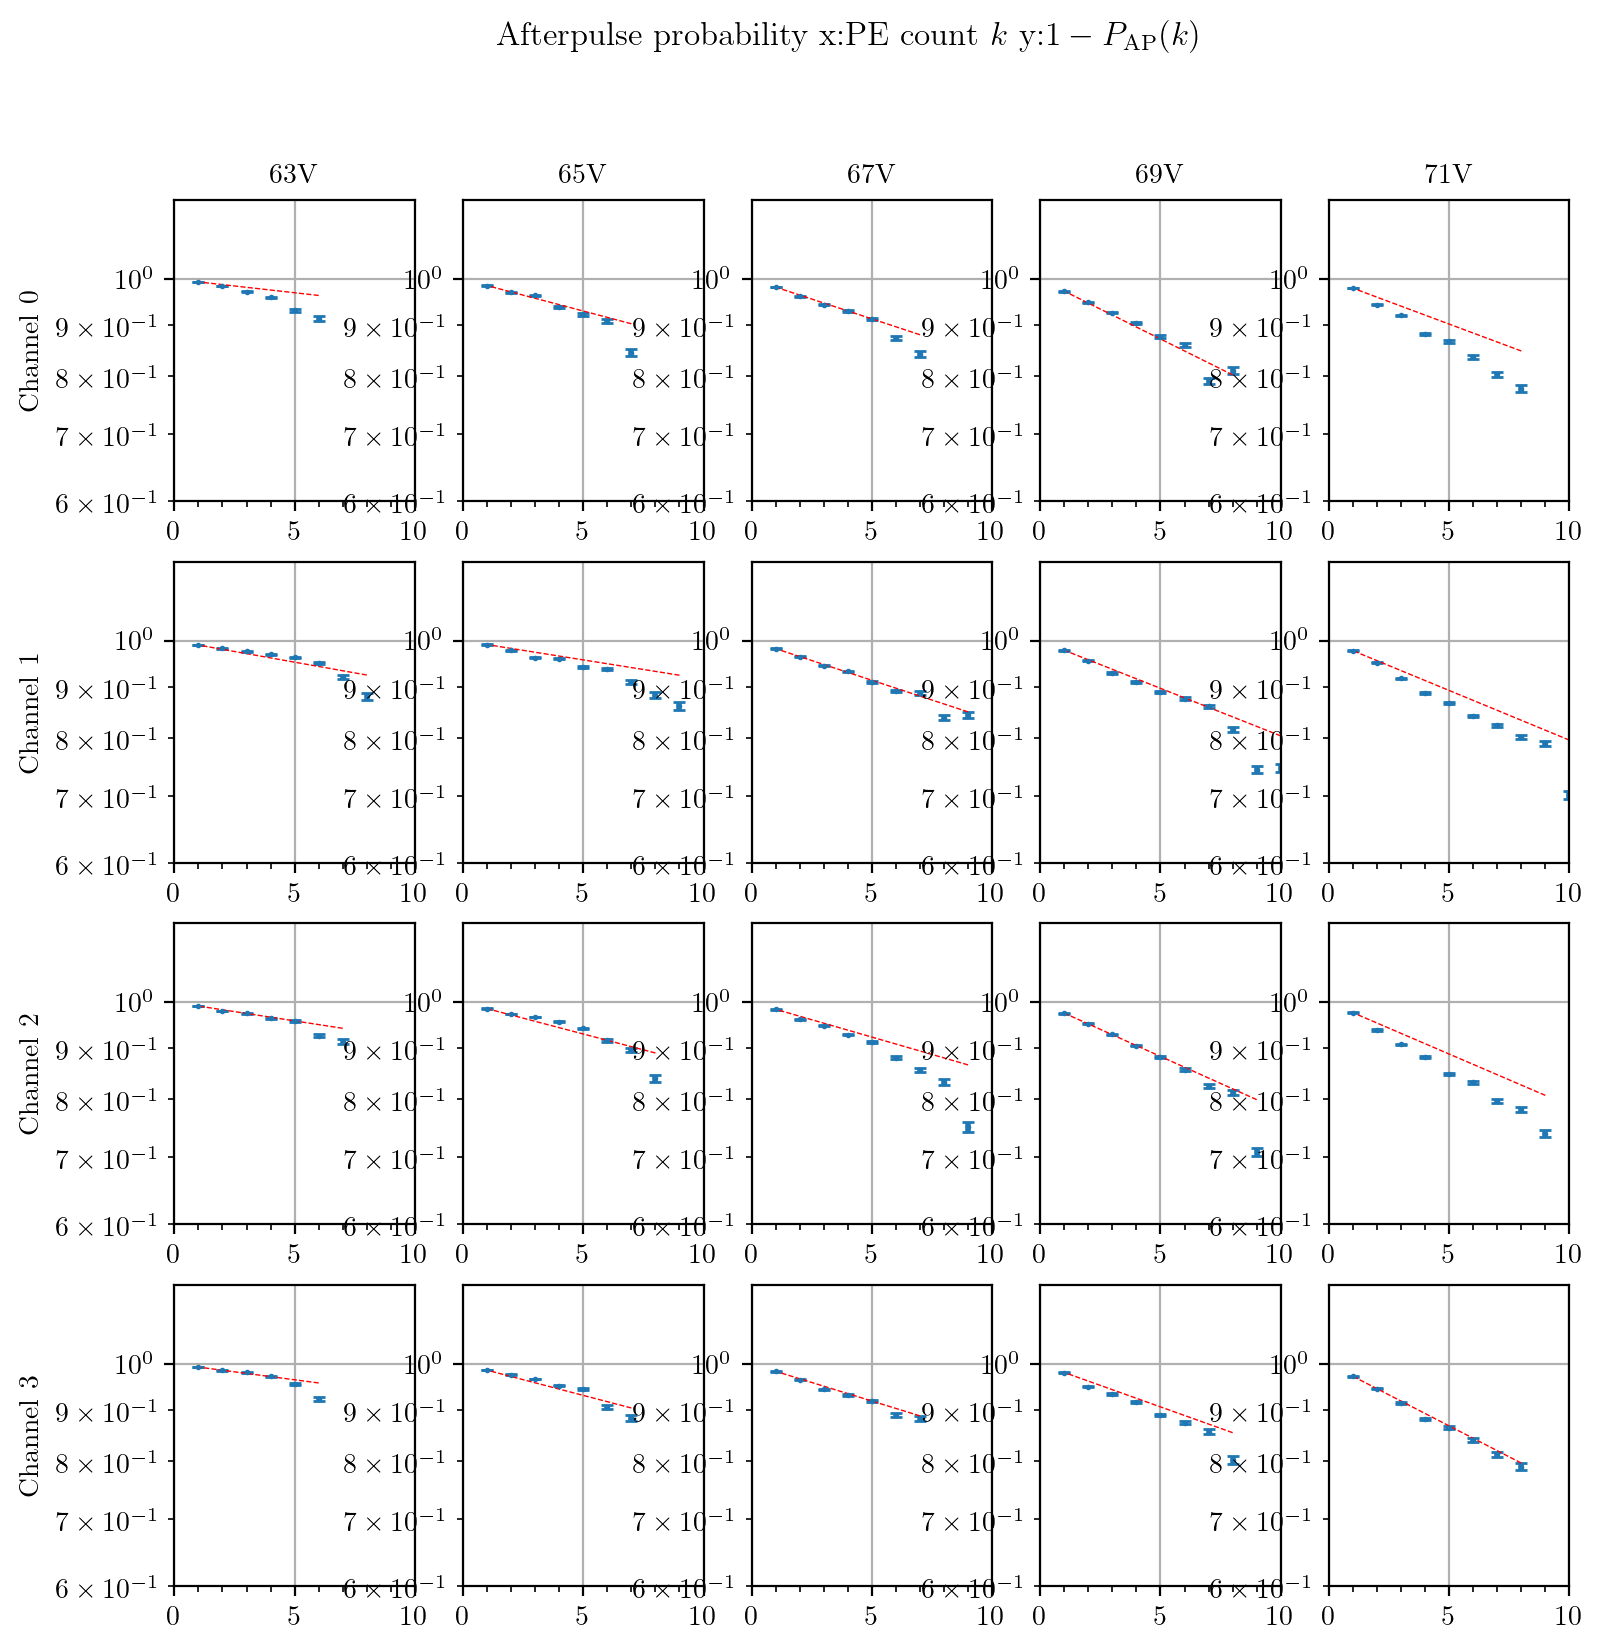

In [8]:
plt.figure(0,figsize=(15,15)) # for charge histograms
plt.suptitle(r'Charge histograms (top) x:charge y:count')
plt.figure(1,figsize=(9,9)) # for I_k fits
plt.suptitle(r'Gain fit (top) x:PE count ($k$) y:charge ($I_k$)')
plt.figure(2,figsize=(3,3)) # for afterpulse
plt.figure(3,figsize=(9,3)) # for Vbd
plt.suptitle('Breakdown voltage fit (top)')
plt.figure(4,figsize=(3,3)) # histogram for one particular channel
plt.figure(5,figsize=(3,3)) # gain-bias fit for one particular channel
plt.figure(6,figsize=(9,9)) # 1-P_ap(k) vs [1-P_ap(1)]^k
Vbd_charge_top = np.zeros((4,2)) # store breakdown voltage

# choice of channel and voltage for histogram
chn = 0
iv = 1

for ch in range(4):
    for i,data in enumerate(ds1122top):
        # charge histogram binning
        x_min=-0.1e4
        x_max=6e3+i*2e3
        n_bins=1000
        bin_w = (x_max-x_min)/n_bins
        Ik_peak = [] 
        Ik_avg = []
        counts = []
        counts_noap = []
        # make histogram
        data.ch[ch].get_charge_histo_pe(bin=[x_min, x_max, n_bins])
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.xlim(x_min, x_max)
        plt.ylim(1,5e3)
        plt.yscale('log')
        plt.minorticks_on()
        plt.grid()
        # analyze histogram for each PE count
        maxpe = len(data.ch[ch].ap_charge)-1
        for j in np.arange(maxpe,0,-1):
            # Calculate mean and std in the histogram range
            all_charge_nparray = np.array(data.ch[ch].ap_charge[j])
            charge_mean = np.mean(all_charge_nparray, where=np.logical_and(all_charge_nparray>x_min, all_charge_nparray<x_max))
            charge_std = np.std(all_charge_nparray, where=np.logical_and(all_charge_nparray>x_min, all_charge_nparray<x_max))
            charge_count = np.sum(np.logical_and(all_charge_nparray>x_min, all_charge_nparray<x_max))
            counts.append(charge_count)
            Ik_avg.append([charge_mean, charge_std/np.sqrt(charge_count)])
            plt.figure(0)
            plt.stairs(data.ch[ch].ap_charge_hist[j], data.ch[ch].ap_charge_hist_bin[j])
            p = np.argmax(data.ch[ch].ap_charge_hist[j]) # in bins
            fit1 = p
            fit2 = p
            while data.ch[ch].ap_charge_hist[j][fit1]>0.02*data.ch[ch].ap_charge_hist[j][p]:
                fit1 -= 1
            if data.ch[ch].ap_charge_hist[j][fit1]==0:
                fit1 += 1
            while data.ch[ch].ap_charge_hist[j][fit2]>0.3*data.ch[ch].ap_charge_hist[j][p]:
                fit2 += 1
            if data.ch[ch].ap_charge_hist[j][fit2]==0:
                fit2 -= 1
            popt,pcov = curve_fit(func.gauss_normalized, 0.5*(data.ch[ch].ap_charge_hist_bin[j][fit1:fit2]+data.ch[ch].ap_charge_hist_bin[j][fit1+1:fit2+1]), data.ch[ch].ap_charge_hist[j][fit1:fit2], p0=[np.max(data.ch[ch].ap_charge_hist[j])*(fit2-fit1)*bin_w/3,p*bin_w+x_min,(fit2-fit1)*bin_w/3], sigma=np.sqrt(data.ch[ch].ap_charge_hist[j][fit1:fit2]), maxfev=100000)
            plt.plot(data.ch[ch].ap_charge_hist_bin[j][fit1:fit2], func.gauss_normalized(data.ch[ch].ap_charge_hist_bin[j][fit1:fit2], *popt), 'k--', linewidth=1)
            Ik_peak.append([popt[1],func.error_distance(df=3,sigma=1)*np.sqrt(pcov[1,1])])
            counts_noap.append(popt[0]/bin_w)
            if ch==chn and i==iv:
                plt.figure(4)
                plt.stairs(data.ch[ch].ap_charge_hist[j], data.ch[ch].ap_charge_hist_bin[j], label='{}PE'.format(j))
                plt.plot(data.ch[ch].ap_charge_hist_bin[j][fit1:fit2], func.gauss_normalized(data.ch[ch].ap_charge_hist_bin[j][fit1:fit2], *popt), 'k--', linewidth=1)
                plt.legend(loc='upper right')
                plt.minorticks_on()
                plt.grid()
        # plot 1-P_ap(k) and compare with [1-P_ap(1)]^k
        plt.figure(6)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        pe_counts = np.arange(maxpe,0,-1)
        one_m_pap = np.array(counts_noap)/np.array(counts)
        plt.errorbar(pe_counts, one_m_pap, yerr=np.sqrt(one_m_pap*(1-one_m_pap)/np.array(counts)), fmt='o', markersize=1)
        plt.plot(pe_counts, one_m_pap[-1]**pe_counts, 'r--', linewidth=0.5)
        plt.xlim(0, 10)
        plt.ylim(0.6,1.2)
        plt.yscale('log')
        plt.minorticks_on()
        plt.grid()

        # plot mu-pe vs avg-pe
        Ik_peak = list(reversed(Ik_peak))
        Ik_avg = list(reversed(Ik_avg))
        plt.figure(1)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        # Q_peak fit
        plt.errorbar(np.arange(maxpe)+1, np.array(Ik_peak)[:,0], yerr=np.array(Ik_peak)[:,1], fmt='r.', markersize=2, label=r'$I_{k,\rm peak}$')
        popt,pcov=curve_fit(func.line_simple,np.arange(maxpe)+1, np.array(Ik_peak)[:,0], p0=[500,0], sigma=np.array(Ik_peak)[:,1], maxfev=10000)
        # print('Q_peak = {:.3f}+/-{:.3f}'.format(popt[0], np.sqrt(pcov[0,0])))
        data.ch[ch].gain_peak=[popt[0],func.error_distance(df=2,sigma=1)*np.sqrt(pcov[0,0])]
        plt.plot(np.arange(maxpe)+1, func.line_simple(np.arange(maxpe)+1, *popt), 'r--', label=r'$I_{k,\rm peak}$ fit', linewidth=1)
        if ch==chn and i==iv:
            plt.figure(5)
            plt.errorbar(np.arange(maxpe)+1, np.array(Ik_peak)[:,0], yerr=np.array(Ik_peak)[:,1], fmt='ro', markersize=2, label=r'$I_{k,\rm peak}$')
            plt.plot(np.arange(maxpe)+1, func.line_simple(np.arange(maxpe)+1, *popt), 'r--', label=r'$I_{k,\rm peak}$ fit', linewidth=1)
        plt.figure(1)
        # Q_avg fit
        plt.errorbar(np.arange(maxpe)+1, np.array(Ik_avg)[:,0], yerr=np.array(Ik_avg)[:,1], fmt='b.', markersize=2, label=r'$I_{k,\rm avg}$')
        popt_,pcov_=curve_fit(func.line_simple,np.arange(maxpe)+1,np.array(Ik_avg)[:,0], p0=[500,0], sigma=np.array(Ik_avg)[:,1], maxfev=10000)
        # print('Q_avg = {:.3f}+/-{:.3f}'.format(popt_[0], np.sqrt(pcov_[0,0])))
        data.ch[ch].gain_avg=[popt_[0],func.error_distance(df=2,sigma=1)*np.sqrt(pcov_[0,0])]
        plt.plot(np.arange(maxpe)+1, func.line_simple(np.arange(maxpe)+1, *popt_), 'b--', label=r'$I_{k,\rm avg}$ fit', linewidth=1)
        if ch==chn and i==iv:
            plt.figure(5)
            plt.errorbar(np.arange(maxpe)+1, np.array(Ik_avg)[:,0], yerr=np.array(Ik_avg)[:,1], fmt='bo', markersize=2, label=r'$I_{k,\rm avg}$')
            plt.plot(np.arange(maxpe)+1, func.line_simple(np.arange(maxpe)+1, *popt_), 'b--', label=r'$I_{k,\rm avg}$ fit', linewidth=1)
        plt.figure(1)
        plt.xlim(0,10)
        plt.ylim(0,1.6e4)
        plt.legend()
        plt.grid()
        plt.minorticks_on()
        data.ch[ch].ap=[popt_[0]/popt[0]-1, func.error_distance(df=2,sigma=1)*popt_[0]/popt[0]*np.sqrt(pcov[0,0]/popt[0]**2+pcov_[0,0]/popt_[0]**2)]

    # plot after-pulses
    plt.figure(2)
    plt.errorbar(bias, [data.ch[ch].ap[0] for data in ds1122top], yerr=[data.ch[ch].ap[1] for data in ds1122top], label='CH{}'.format(ch), fmt='o', markersize=2)

    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].gain_peak[0] for data in ds1122top]
    err = [data.ch[ch].gain_peak[1] for data in ds1122top]
    popt,pcov = curve_fit(func.line, xlin, ylin, sigma=err, p0=[100, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],func.error_distance(df=2,sigma=1)*np.sqrt(pcov[1,1]),popt[0],func.error_distance(df=2,sigma=1)*np.sqrt(pcov[0,0])))
    Vbd_charge_top[ch,:] = np.array([popt[1],func.error_distance(df=2,sigma=1)*np.sqrt(pcov[1,1])])
    plt.figure(3)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel(r'SPE Gain $Q_{\rm peak}$ [A.U.]')
    plt.xlabel('Bias [V]')
    plt.errorbar(xlin,ylin,yerr=err,fmt='o', markersize=2)
    plt.plot(sorted(xlin+[popt[1]]),func.line(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,1000)
    plt.minorticks_on()
    plt.grid()

plt.figure(2)
plt.legend()
plt.minorticks_on()
plt.grid()
plt.xlabel('Bias Voltage [V]')
plt.ylabel('Afterpulse charge [PE/PE]')
plt.xlim(62,72)
plt.ylim(-0.01, 0.1)

plt.figure(4)
plt.yscale('log')
#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = np.arange(len(labels)-1, -1, -1)
#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='upper right')
plt.minorticks_on()
plt.grid()
plt.ylim(1e0, 5e3)
plt.xlim(x_min, 6e3+2e3*iv)
plt.xlabel('Charge [A.U.]')
plt.ylabel('Count')

plt.figure(5)
plt.xlabel(r'PE count $k$')
plt.ylabel(r'Integral $I_k$ [A.U.]')
plt.xlim(0,10)
plt.ylim(0,7e3)
#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = [3,1,2,0]
#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='upper left')
plt.minorticks_on()
plt.grid()

plt.figure(6)
plt.suptitle(r'Afterpulse probability x:PE count $k$ y:$1-P_{\rm AP}(k)$')

# Bottome tile calibration (1122 data)

## Load data

In [9]:
bias = [63, 65, 67, 69, 71]
ds1122bot = []
for i,volt in enumerate(bias):
    dset = wfd.WaveformDataset(path='', channels=range(4))
    file = ROOT.TFile("/scratch/gpfs/as111/root/calibration_1122_{}V_bottom.root".format(volt), "read")
    tree = file.Get("tree")
    nev = 0
    nev_cut = [0,0,0,0]
    for ch in dset.ch:
        ch.baseline_avg = []
        ch.baseline_std = []
        ch.famp = []
        ch.integral_long = []
    for iev,ev in enumerate(tree):
        nev += 1
        for ich,ch in enumerate(dset.ch):
            ch.baseline_avg.append(ev.bsl_avg[ich])
            ch.baseline_std.append(ev.bsl_std[ich])
            if(ev.bsl_std[ich]<2.5):
                ch.famp.append(ev.fil_amp[ich])
                ch.integral_long.append(ev.int_long[ich])
                nev_cut[ich] += 1
    file.Close()
    print('Bottom {}V {} events loaded.'.format(volt, nev))
    for ich,ch in enumerate(dset.ch):
        ch.cumulative_nevents = nev
        ch.nevents_aftercut = nev_cut[ich]
        print('Ch{} cut fraction={:.3f}%'.format(ich, 100*(1-nev_cut[ich]/nev)))
    ds1122bot.append(dset)

Bottom 63V 219820 events loaded.
Ch0 cut fraction=0.192%
Ch1 cut fraction=2.682%
Ch2 cut fraction=0.156%
Ch3 cut fraction=1.449%
Bottom 65V 219811 events loaded.
Ch0 cut fraction=0.209%
Ch1 cut fraction=1.623%
Ch2 cut fraction=0.212%
Ch3 cut fraction=2.354%
Bottom 67V 219809 events loaded.
Ch0 cut fraction=0.228%
Ch1 cut fraction=0.812%
Ch2 cut fraction=0.202%
Ch3 cut fraction=1.038%
Bottom 69V 219821 events loaded.
Ch0 cut fraction=0.322%
Ch1 cut fraction=0.522%
Ch2 cut fraction=0.263%
Ch3 cut fraction=0.522%
Bottom 71V 219799 events loaded.
Ch0 cut fraction=0.444%
Ch1 cut fraction=2.142%
Ch2 cut fraction=0.386%
Ch3 cut fraction=1.250%


## Baseline cut

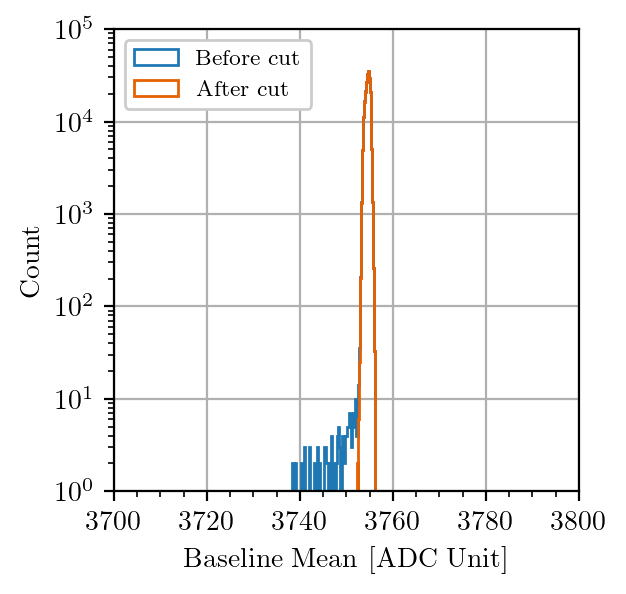

In [10]:
i=0
ch=0
dset = ds1122bot[i].ch[ch]

nbins = 500
range_min = 3700
range_max = 3800
bin_width = (range_max-range_min)/nbins

bsl_avg_cut = []
for ev,avg in enumerate(dset.baseline_avg):
    if dset.baseline_std[ev]<2.5:
        bsl_avg_cut.append(avg)

plt.figure(0,figsize=(3,3))
plt.hist(dset.baseline_avg, label='Before cut', bins=np.linspace(range_min, range_max, nbins+1), histtype='step')
plt.hist(bsl_avg_cut, label='After cut', bins=np.linspace(range_min, range_max, nbins+1), histtype='step')
plt.legend()
plt.yscale('log')
plt.xlabel('Baseline Mean [ADC Unit]')
plt.ylabel('Count')
plt.minorticks_on()
plt.grid()

## Filtered amplitude and direct crosstalk (DiCT)
Repeat analysis

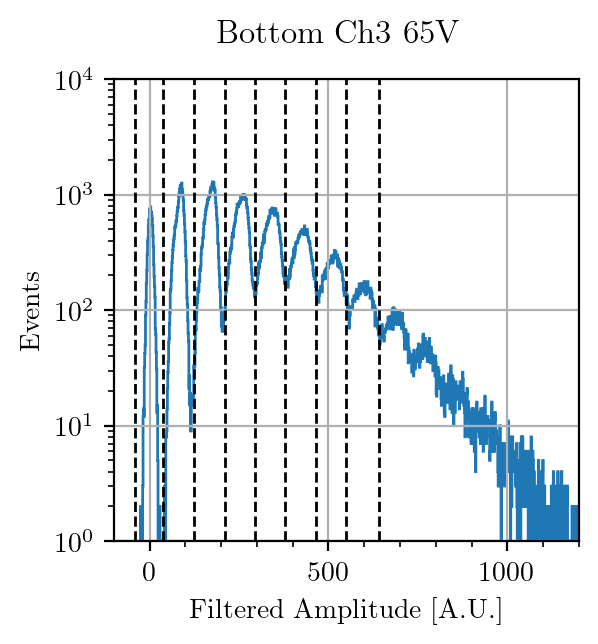

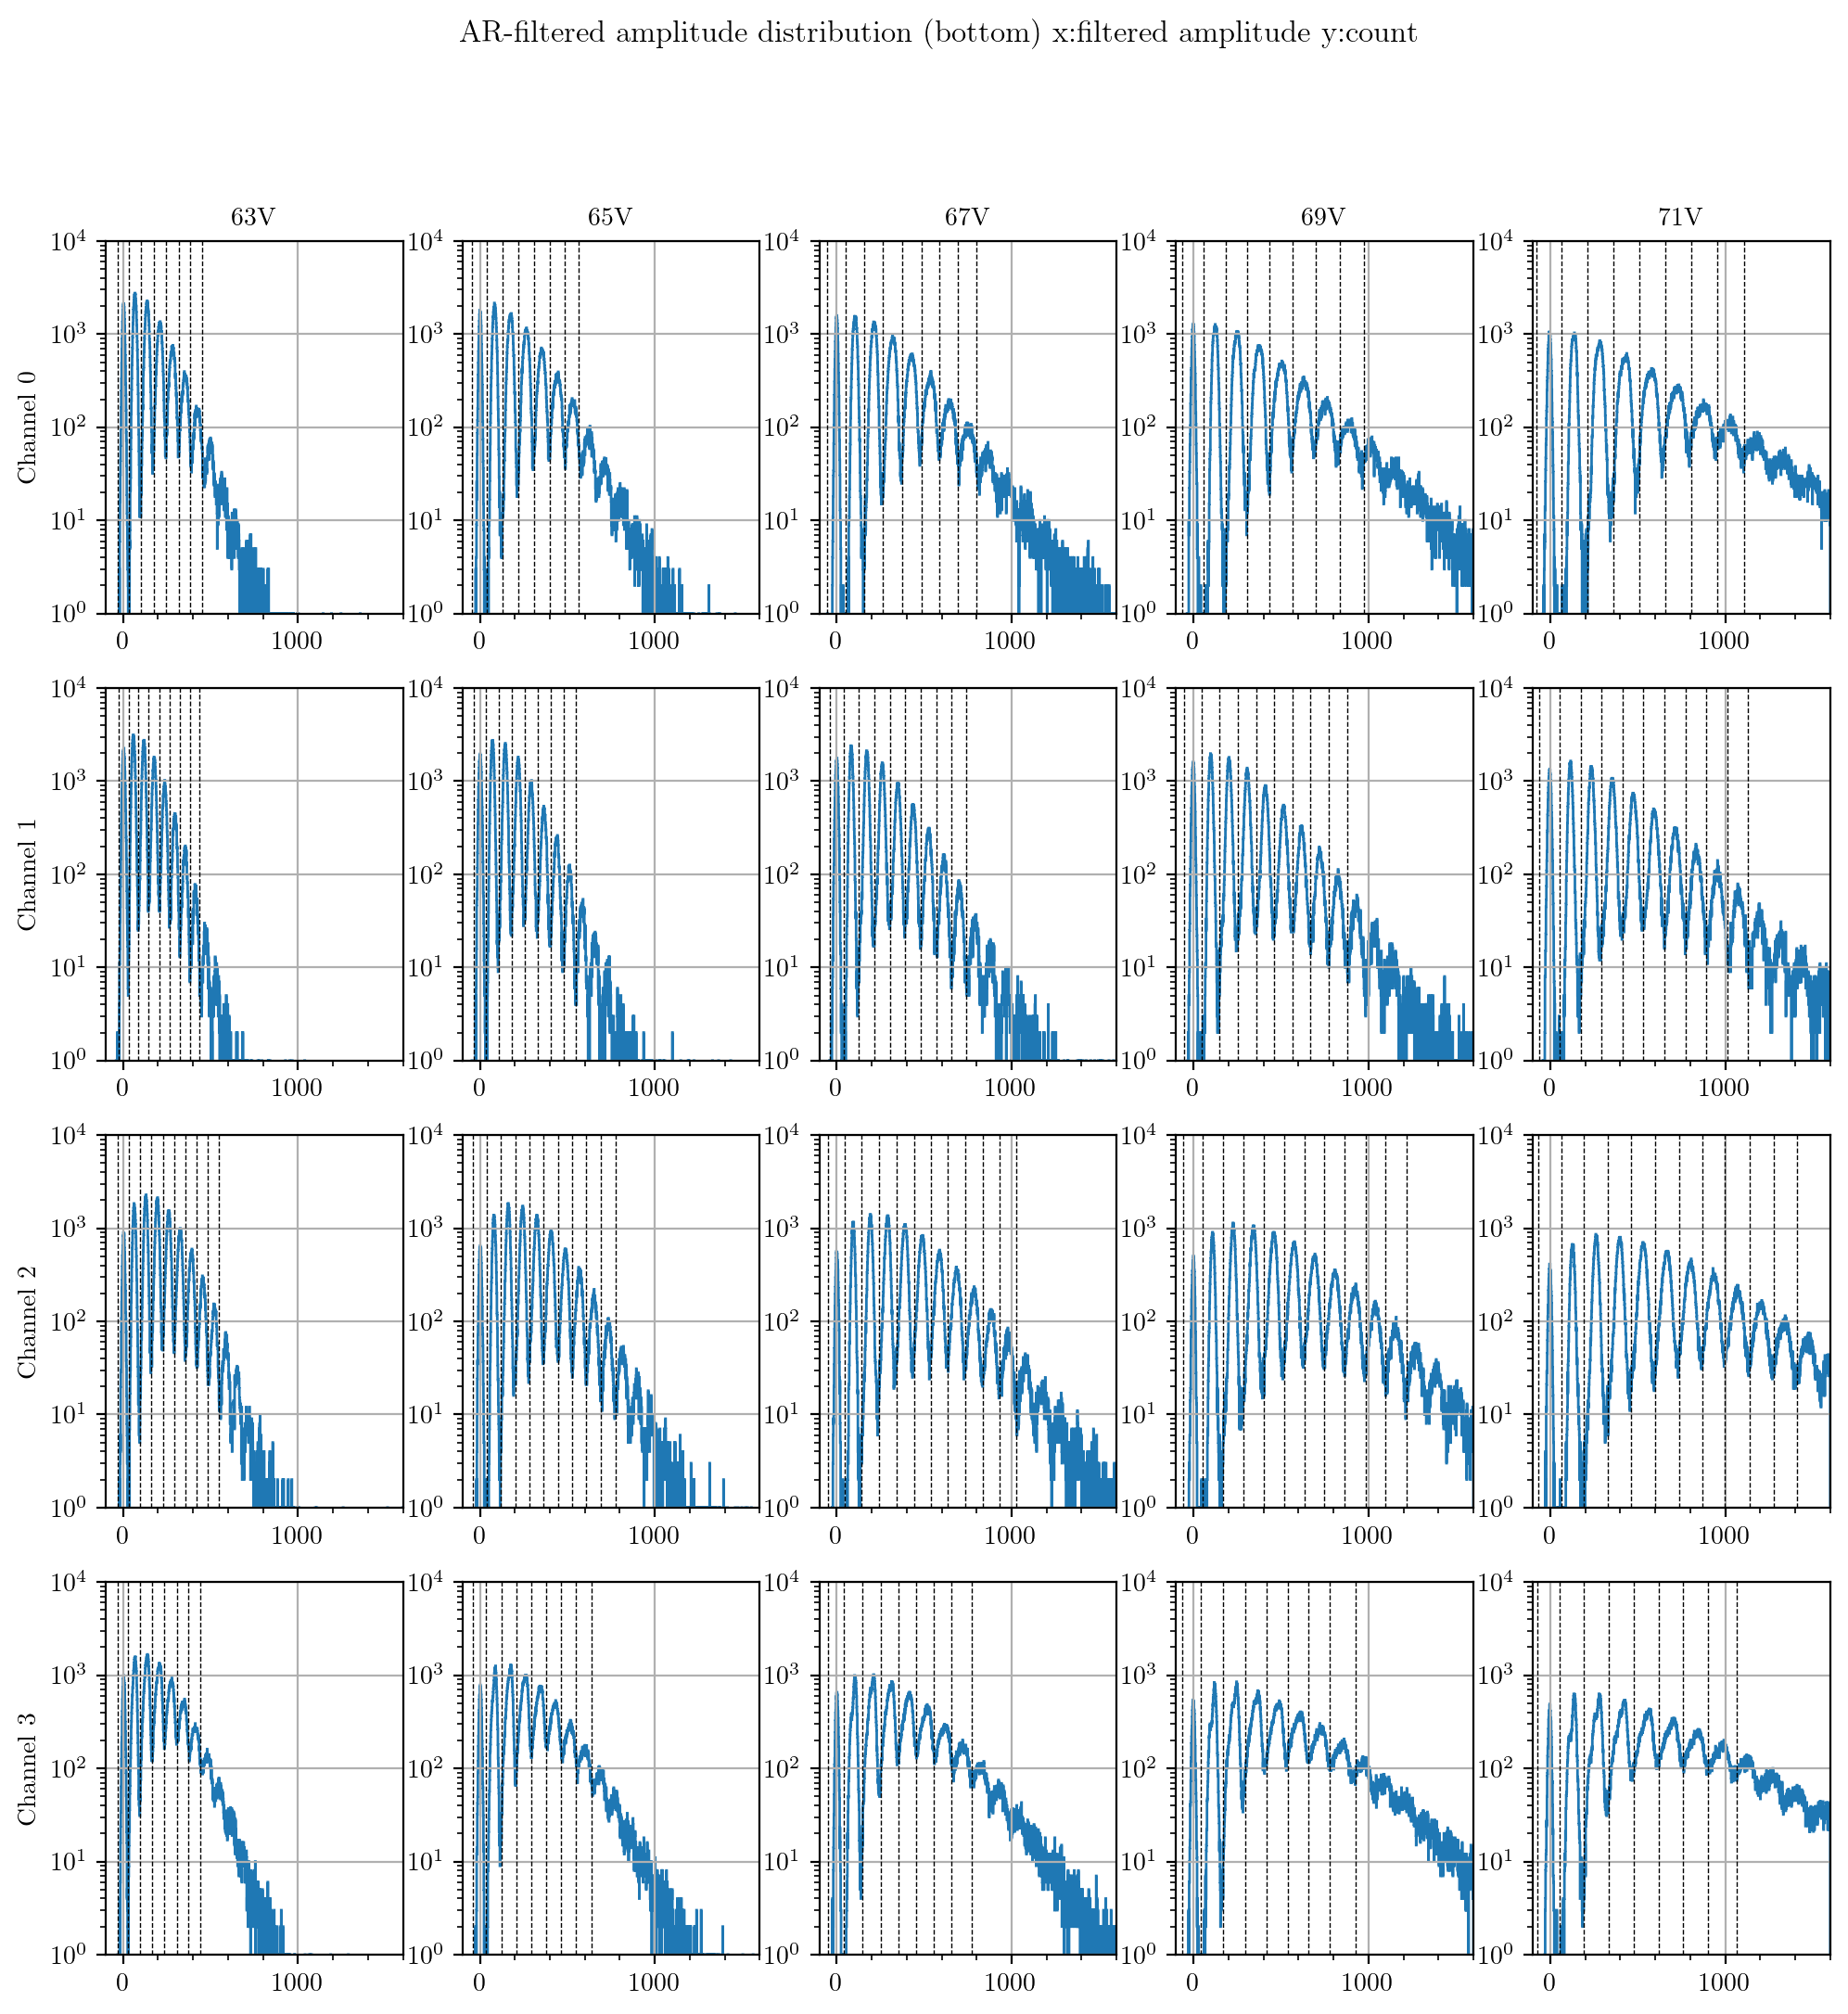

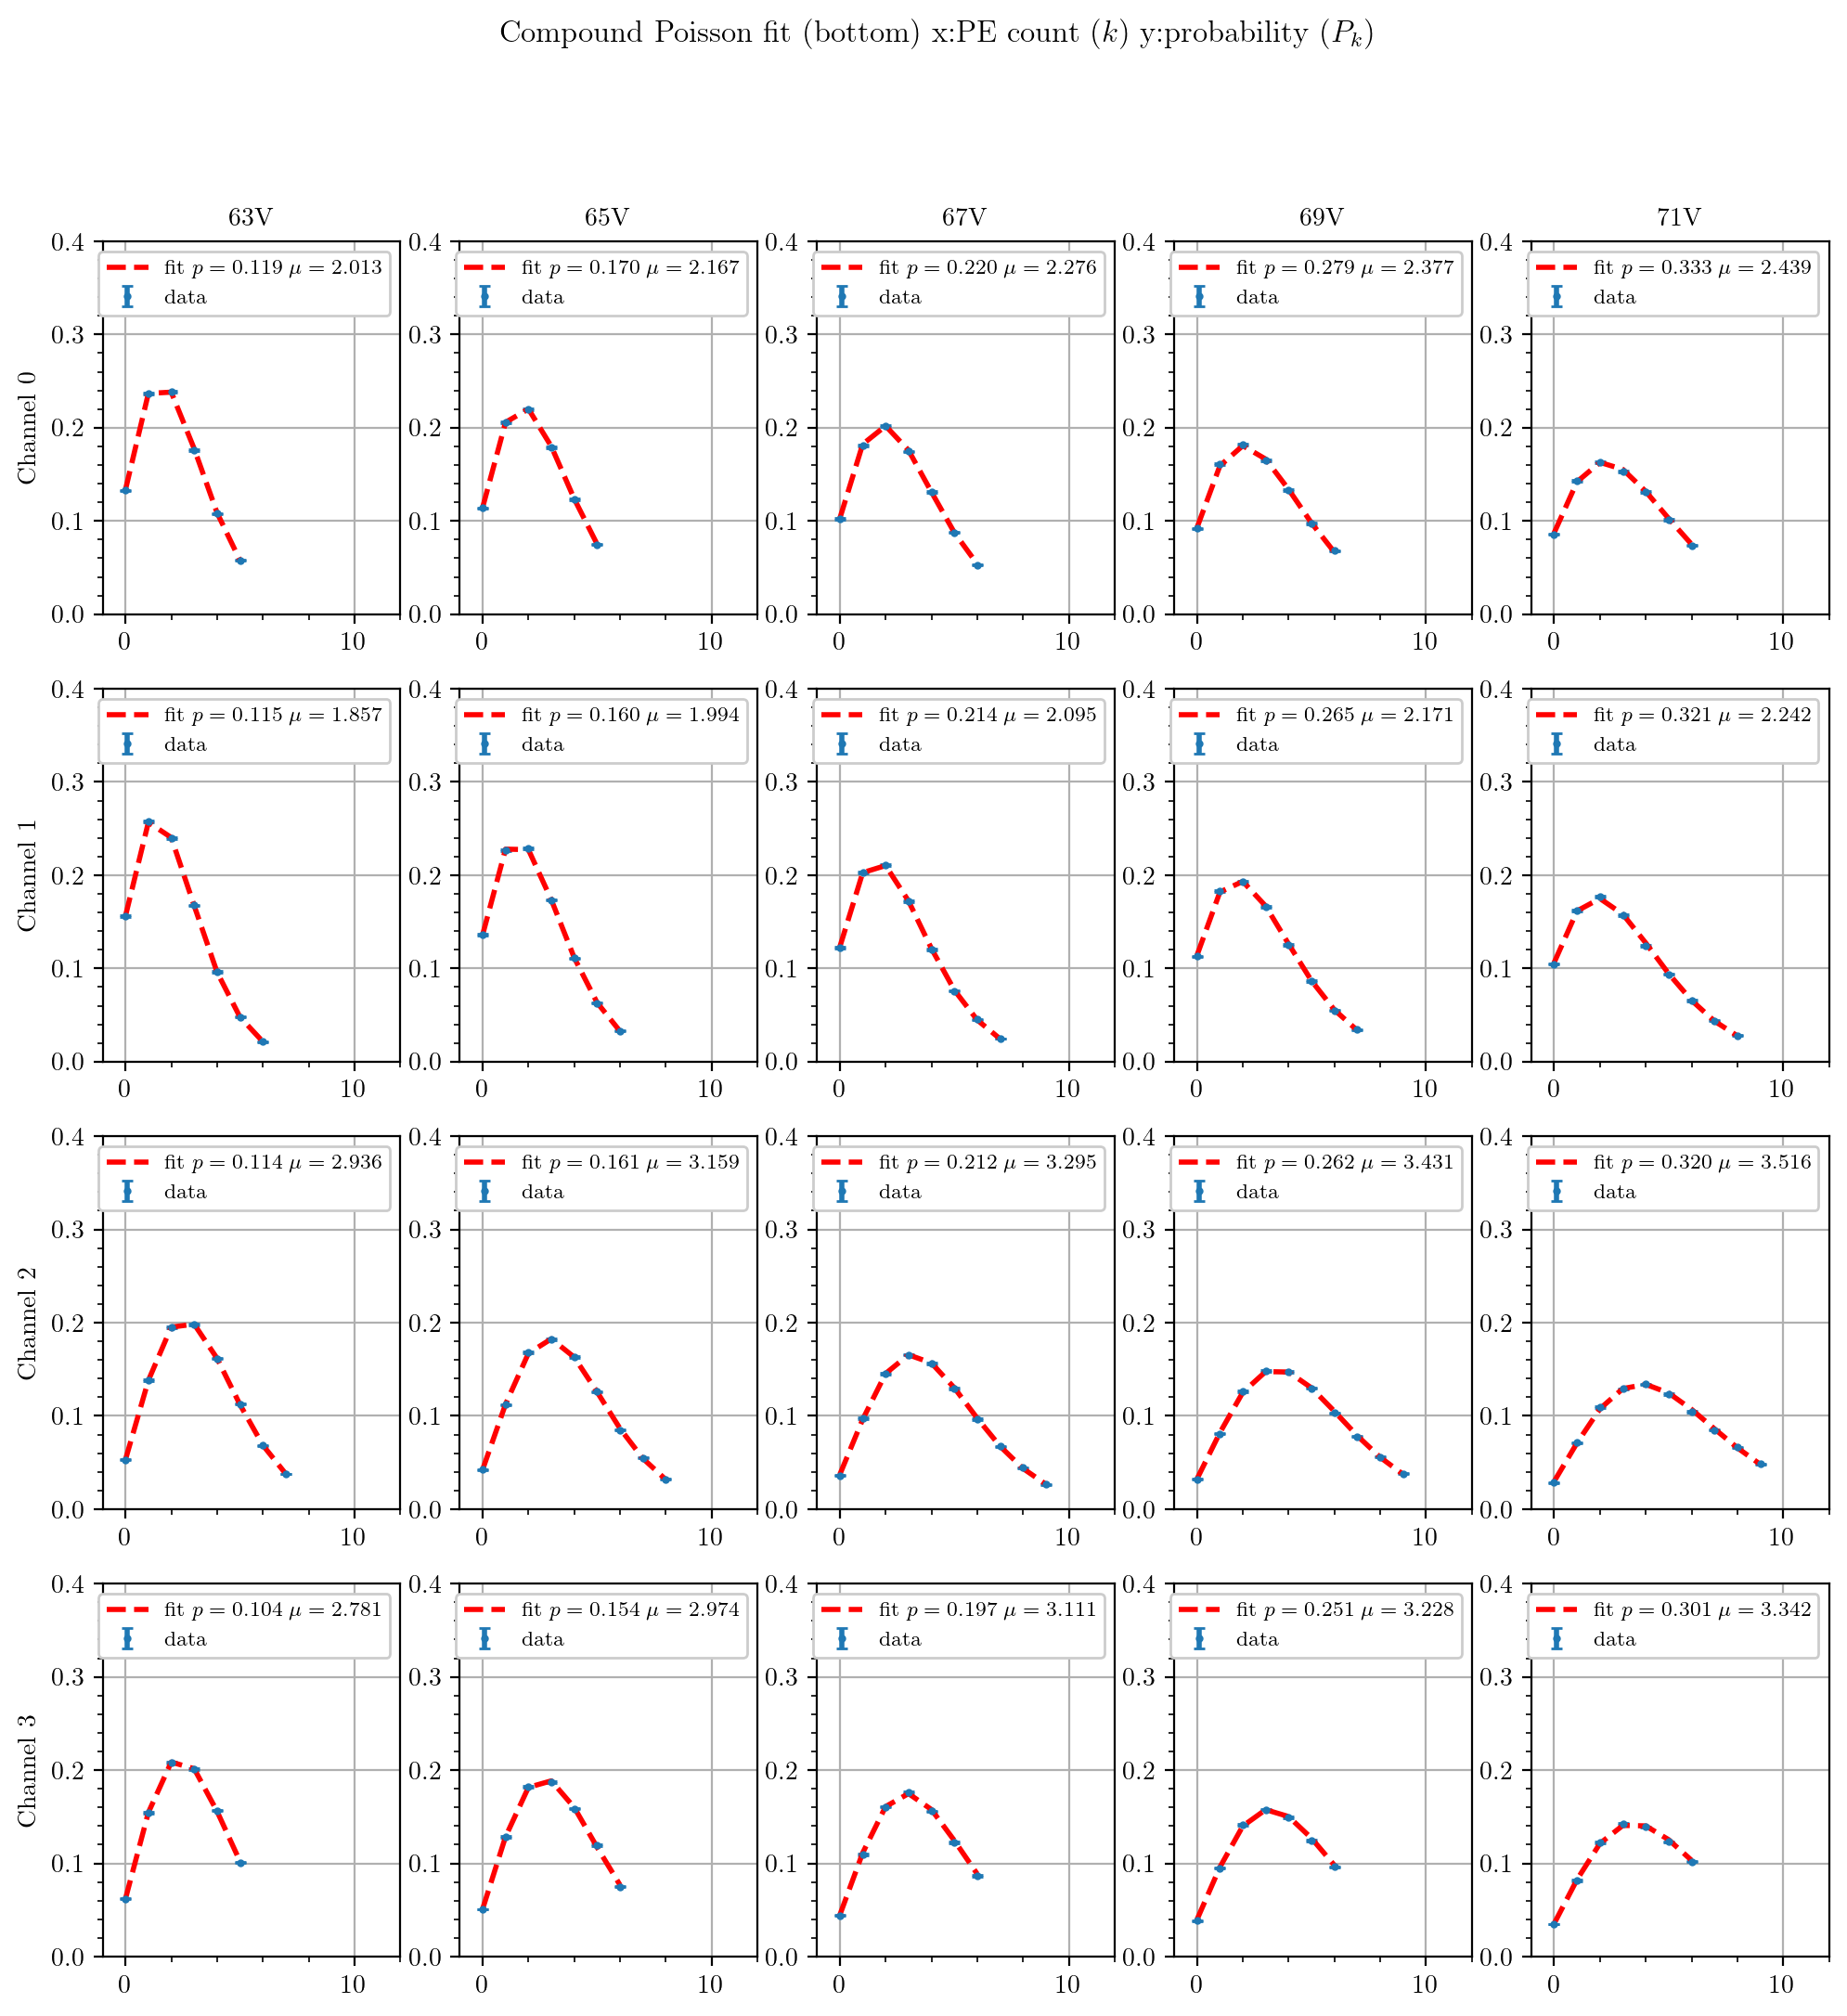

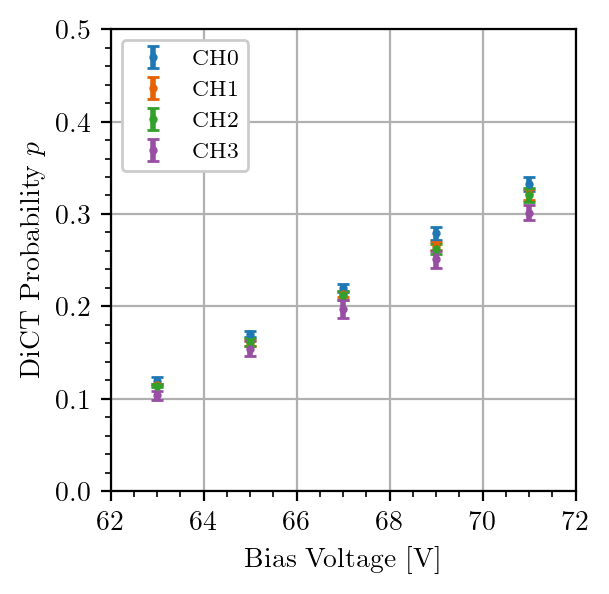

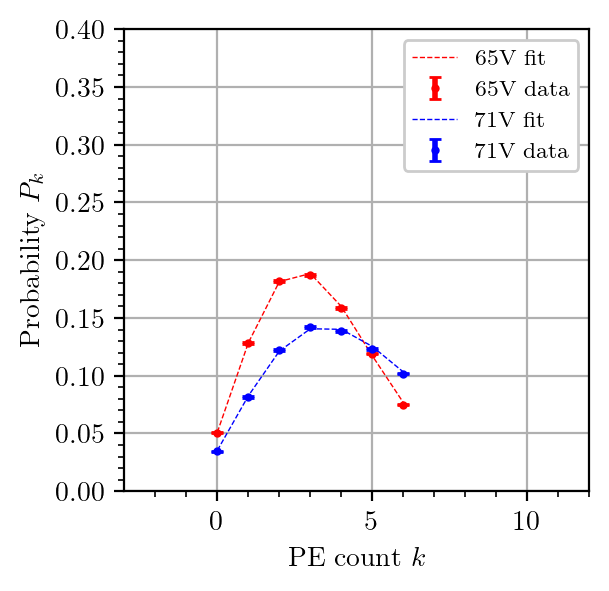

In [11]:
plt.figure(0,figsize=(12,12)) # for filtered amplitude histograms
plt.suptitle(r'AR-filtered amplitude distribution (bottom) x:filtered amplitude y:count')
plt.figure(1,figsize=(12,12)) # for Vinogradov fit
plt.suptitle(r'Compound Poisson fit (bottom) x:PE count ($k$) y:probability ($P_k$)')
plt.figure(2,figsize=(3,3)) # for crosstalk summary
plt.figure(3,figsize=(3,3)) # finger plot for a particular channel
plt.figure(4,figsize=(3,3)) # dict fit for a particular channel

# choice of channel and voltage for finger plot
chn = 3
iv = 1
# additional choice of voltage for vinogradov fit
ivv = 4

# finger plot binning
nbins = 1500
range_min = -1e2
range_max = 1.6e3
bin_width = (range_max-range_min)/nbins

for ch in range(4):
    for i,data in enumerate(ds1122bot):  
        #filtered amplitude histogram
        data.ch[ch].get_famp_hist(bin=[range_min,range_max,nbins])
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.stairs(data.ch[ch].famp_hist, data.ch[ch].famp_hist_bin)
        plt.yscale('log')
        plt.xlim(data.ch[ch].famp_hist_bin[0], data.ch[ch].famp_hist_bin[-1])
        plt.ylim(1, 1e4)
        plt.minorticks_on()
        plt.grid()      
        # find PE peaks in histograms
        data.ch[ch].find_histo_peaks(thre=0, prom=70, wid=10, dist=8)
        # discriminate different PE counts and calculate probability distribution P_k
        P_k = []
        npe = len(data.ch[ch].peaks)
        pe_cuts_in_bins = []
        for ipe in range(npe+1):
            if ch!=3:
                if ipe==0:
                    pe_cuts_in_bins.append(int(1.5*data.ch[ch].peaks[0]-0.5*data.ch[ch].peaks[1]))
                elif ipe==npe:
                    pe_cuts_in_bins.append(int(1.5*data.ch[ch].peaks[-1]-0.5*data.ch[ch].peaks[-2]))
                else:
                    pe_cuts_in_bins.append(int(0.5*(data.ch[ch].peaks[ipe]+data.ch[ch].peaks[ipe-1])))
            else:#ch3 is bad, so we need to adapt the criterion
                if ipe==0:
                    pe_cuts_in_bins.append(int(1.5*data.ch[ch].peaks[0]-0.5*data.ch[ch].peaks[1]))
                elif ipe==npe:
                    pe_cuts_in_bins.append(int(1.5*data.ch[ch].peaks[-1]-0.5*data.ch[ch].peaks[-2]))
                else:
                    pe_cuts_in_bins.append(int(0.4*data.ch[ch].peaks[ipe]+0.6*data.ch[ch].peaks[ipe-1]))
            plt.plot([pe_cuts_in_bins[ipe]*bin_width+range_min, pe_cuts_in_bins[ipe]*bin_width+range_min], [1,1e4], 'k--', linewidth=0.5)
            if ipe>0 and ipe<npe:
                P_k.append([np.sum(data.ch[ch].famp_hist[pe_cuts_in_bins[ipe-1]:pe_cuts_in_bins[ipe]])/data.ch[ch].nevents_aftercut, np.sqrt(np.sum(data.ch[ch].famp_hist[pe_cuts_in_bins[ipe-1]:pe_cuts_in_bins[ipe]]))/data.ch[ch].nevents_aftercut])
        data.ch[ch].pe_cuts = np.array(pe_cuts_in_bins)*bin_width+range_min
        # finger plot for the choice of channel and voltage
        if ch==chn and i==iv:
            plt.figure(3)
            plt.stairs(data.ch[ch].famp_hist, data.ch[ch].famp_hist_bin)
            plt.yscale('log')
            for pe_cut in data.ch[ch].pe_cuts:
                plt.plot([pe_cut, pe_cut], [1,1e4], 'k--', linewidth=1)
            plt.xlabel('Filtered Amplitude [A.U.]')
            plt.ylabel('Events')
            plt.suptitle('Bottom Ch{} {}V'.format(ch, bias[i]))
            plt.xlim(data.ch[ch].famp_hist_bin[0], 1200)
            plt.ylim(1, 1e4)
            plt.minorticks_on()
            plt.grid()
        # vinogradov fit and plot
        plt.figure(1)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.errorbar(np.arange(len(P_k)), np.array(P_k)[:,0], yerr=np.array(P_k)[:,1], fmt='o', markersize=2, label='data')
        popt,pcov = curve_fit(func.compound_poisson, list(np.arange(len(P_k))), np.array(P_k)[:,0], p0=[2, 0.2], sigma=np.array(P_k)[:,1], maxfev=10000)
        data.ch[ch].dict = [popt[1],func.error_distance(df=2,sigma=1)*np.sqrt(pcov[1,1])]
        plt.plot(np.arange(len(P_k)), func.compound_poisson(np.arange(len(P_k)),*popt), 'r--', label=r'fit $p={:.3f}$ $\mu={:.3f}$'.format(popt[1],popt[0]))
        plt.ylim(0,0.4)
        plt.xlim(-1,12)
        plt.legend(loc='upper right')
        plt.minorticks_on()
        plt.grid()
        # vinogradov plot for the choice of channel and voltages
        if ch==chn and (i==iv or i==ivv):
            plt.figure(4)
            if i==iv:
                color='r'
            else:
                color='b'
            plt.errorbar(np.arange(len(P_k)), np.array(P_k)[:,0], yerr=np.array(P_k)[:,1], fmt='{}o'.format(color), markersize=2, label='{}V data'.format(bias[i]))
            plt.plot(np.arange(len(P_k)), func.compound_poisson(np.arange(len(P_k)),*popt), '{}--'.format(color), label='{}V fit'.format(bias[i]), linewidth=0.5)
    # plot crosstalk
    plt.figure(2)
    plt.errorbar(bias, [data.ch[ch].dict[0] for data in ds1122bot], yerr=[data.ch[ch].dict[1] for data in ds1122bot], label='CH{}'.format(ch), fmt='o', markersize=2)
    
# adjust figures    
plt.figure(2)
plt.legend()
plt.xlabel('Bias Voltage [V]')
plt.ylabel(r'DiCT Probability $p$')
plt.grid()
plt.minorticks_on()
plt.xlim(62,72)
plt.ylim(0, 0.5)

plt.figure(4)
plt.ylim(0,0.4)
plt.xlim(-3,12)
plt.xlabel(r'PE count $k$')
plt.ylabel(r'Probability $P_k$')
#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = [0,2,1,3]
#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='upper right')
plt.minorticks_on()
plt.grid()

## Afterpulsing
Repeat analysis


Channel 0 Vbd=54.408+/-0.197V slope=51.511+/-0.959
Channel 1 Vbd=53.702+/-0.564V slope=44.532+/-1.908
Channel 2 Vbd=53.931+/-0.299V slope=48.156+/-1.255
Channel 3 Vbd=53.786+/-0.451V slope=48.247+/-1.797


Text(0.5, 0.98, 'Afterpulse probability x:PE count $k$ y:$1-P_{\\rm AP}(k)$')

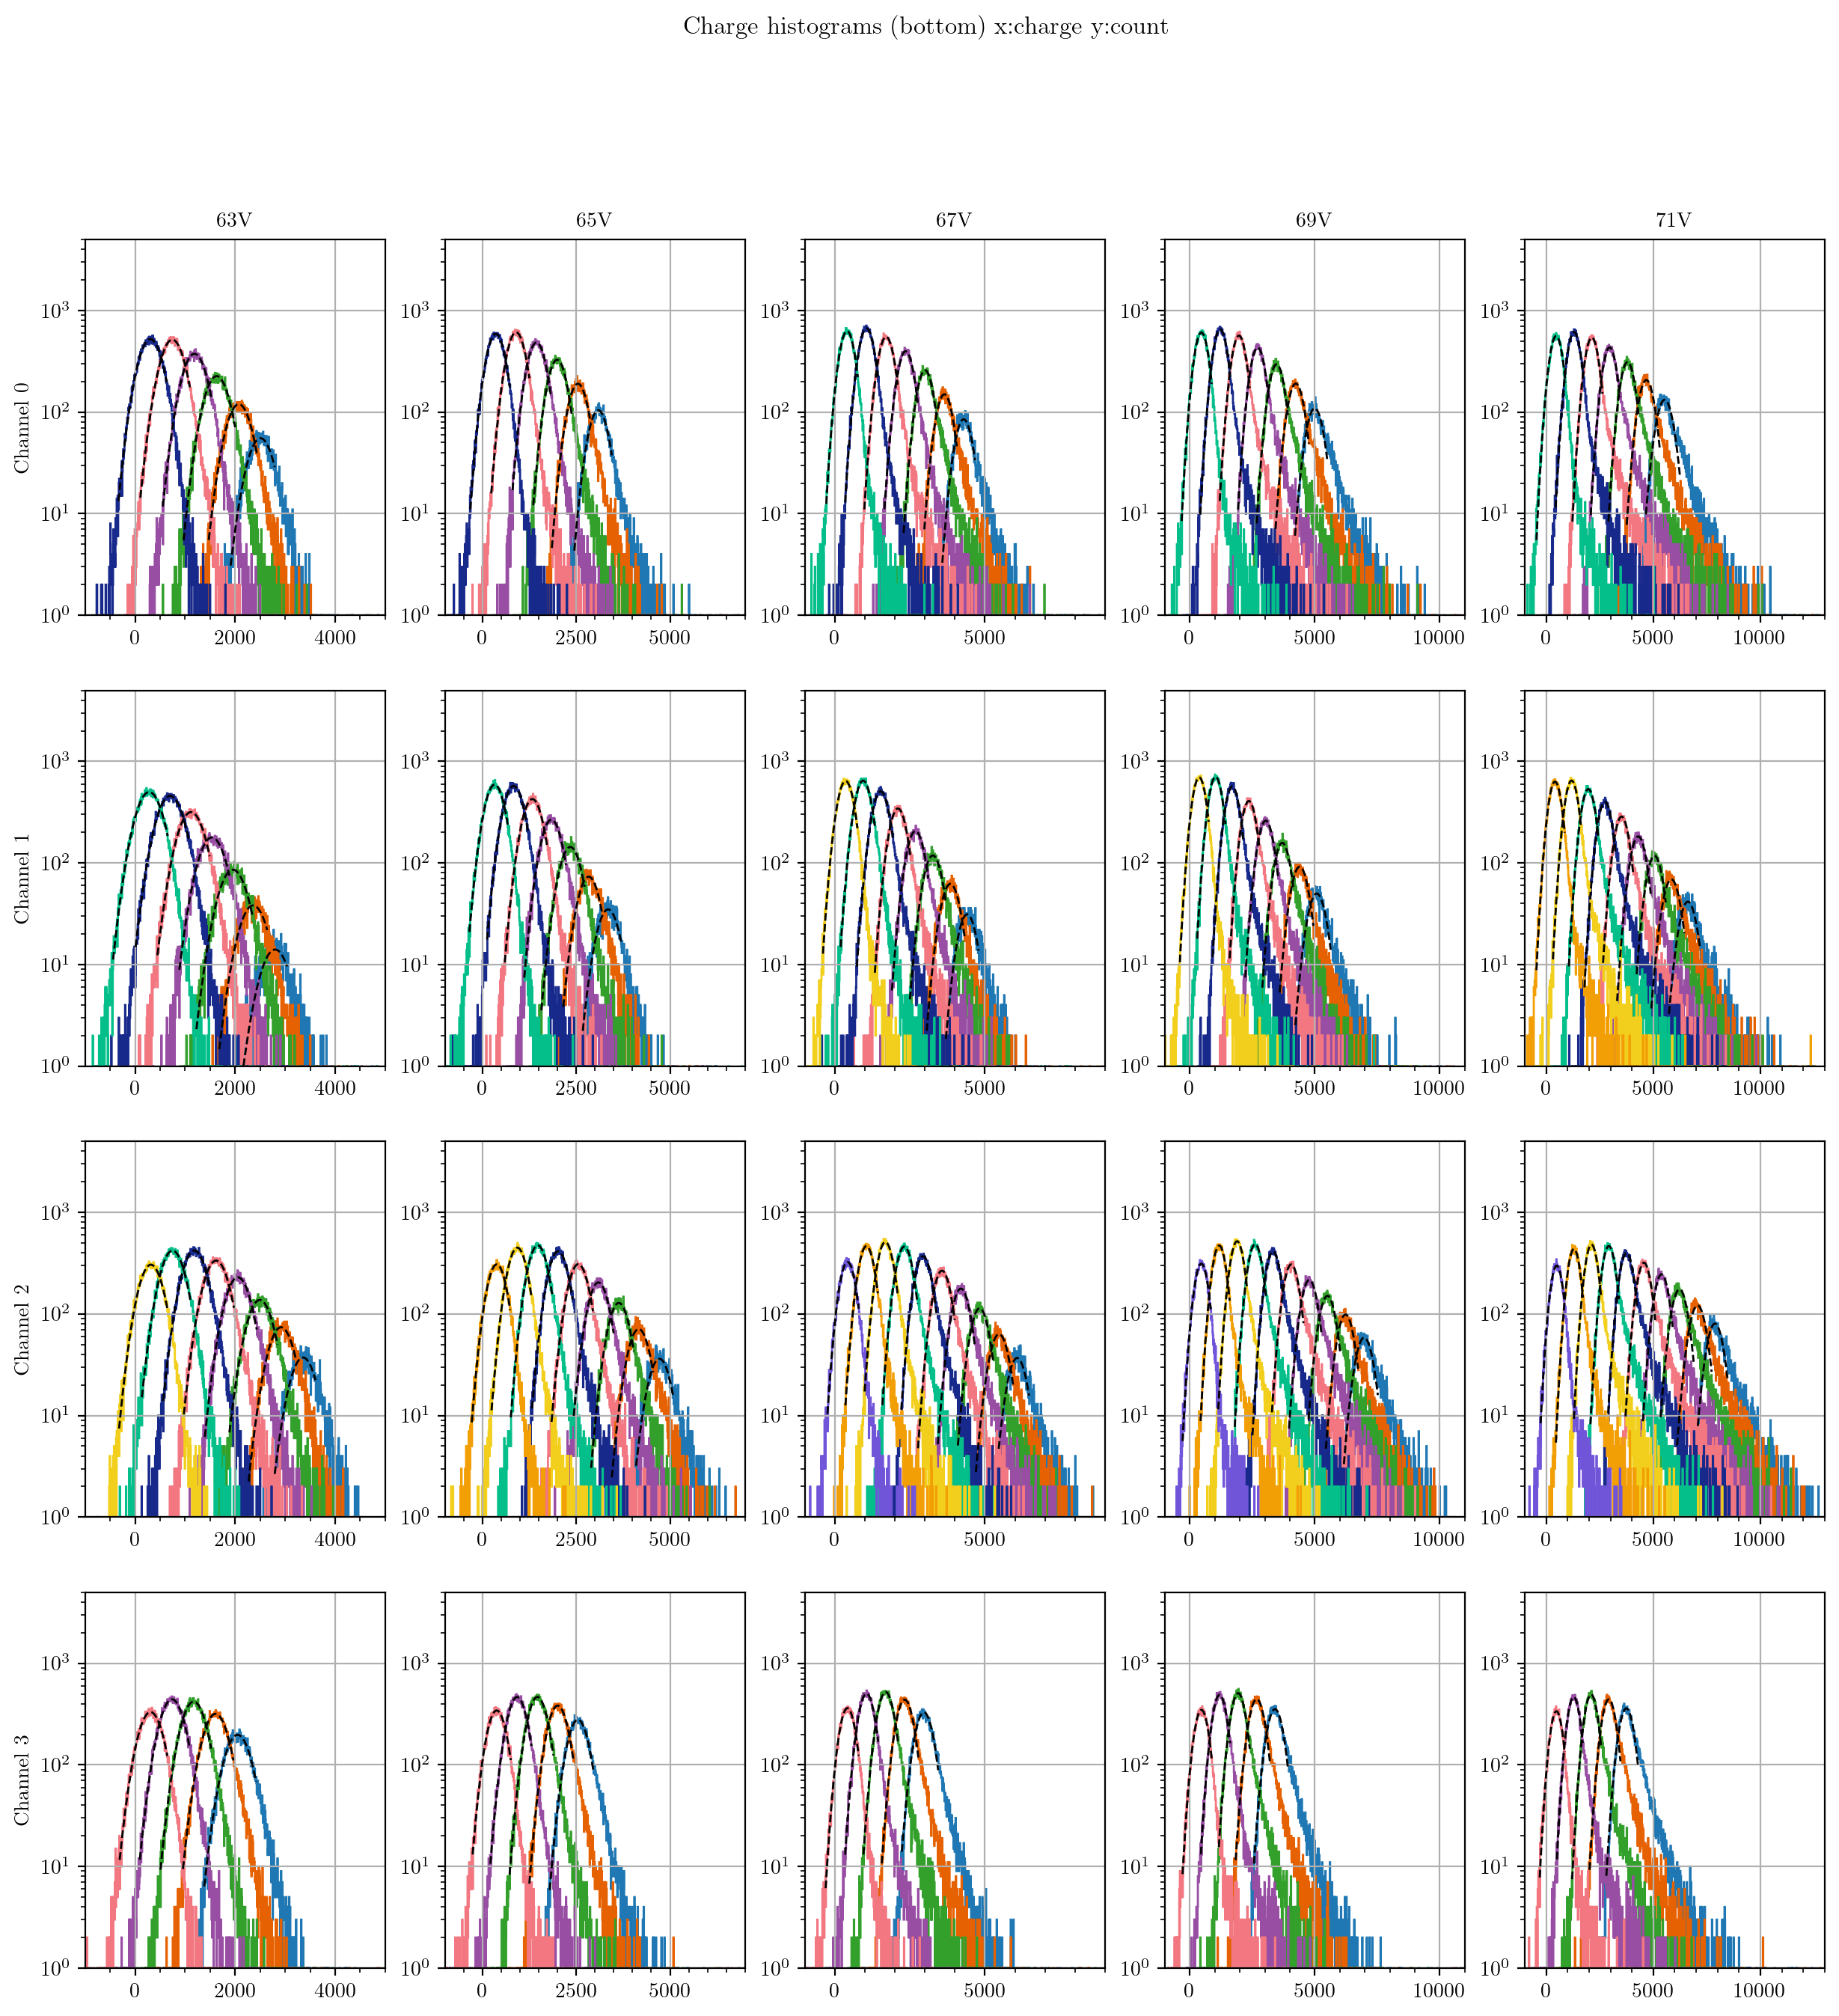

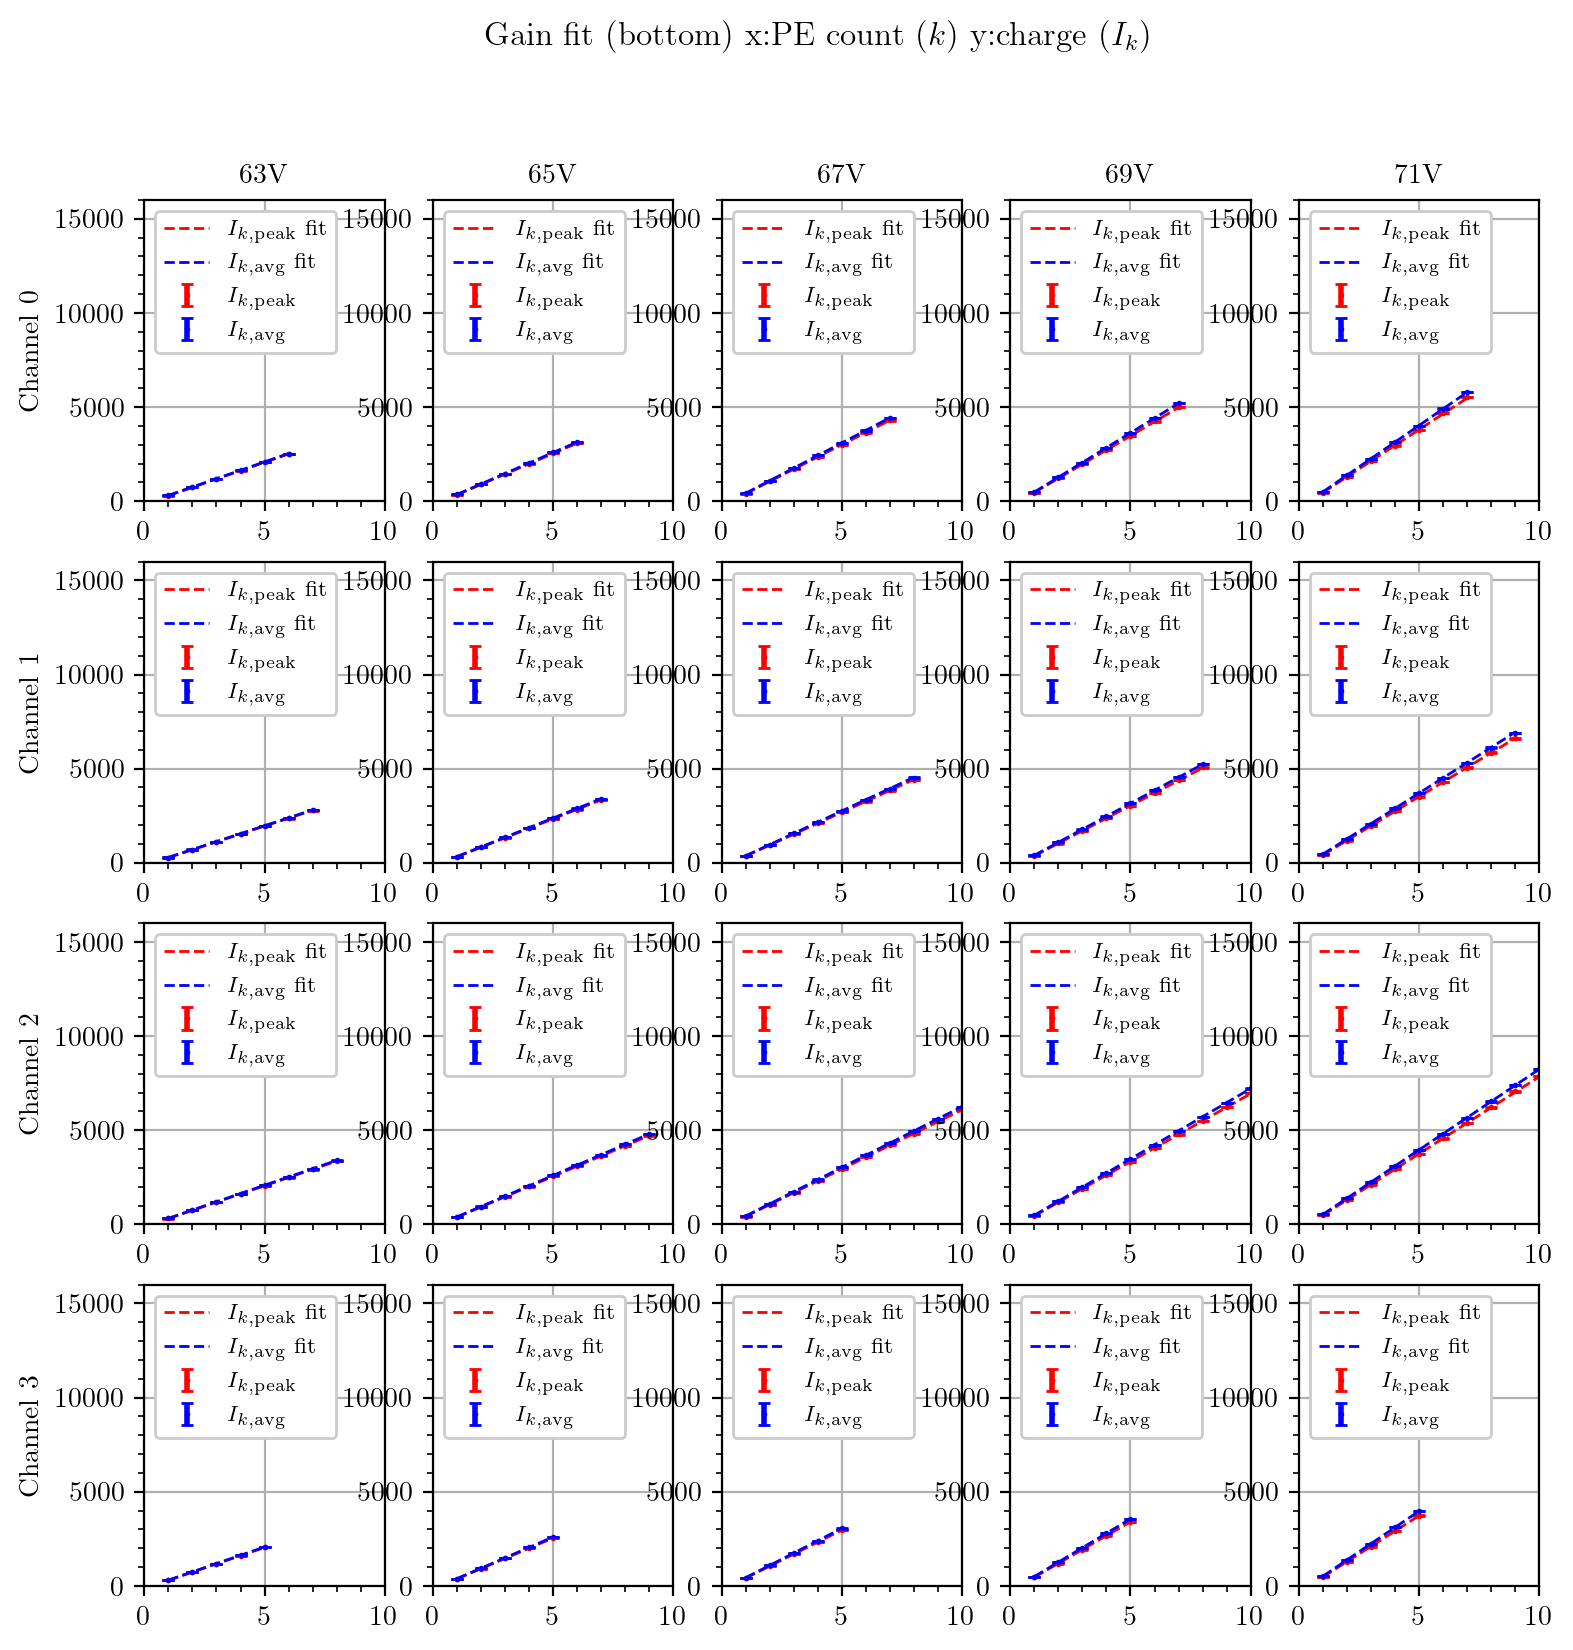

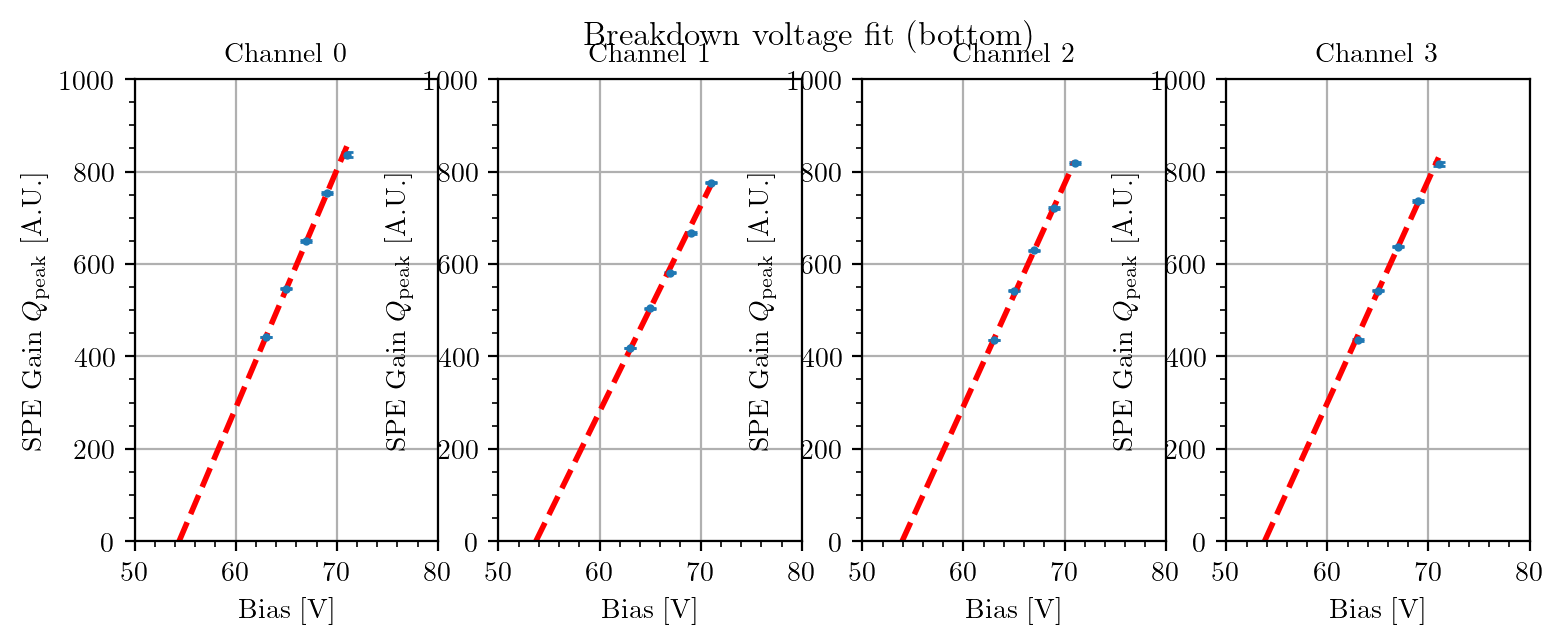

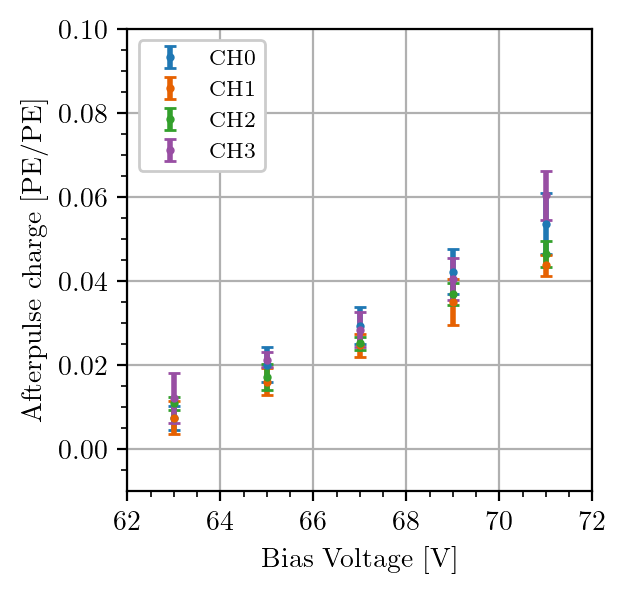

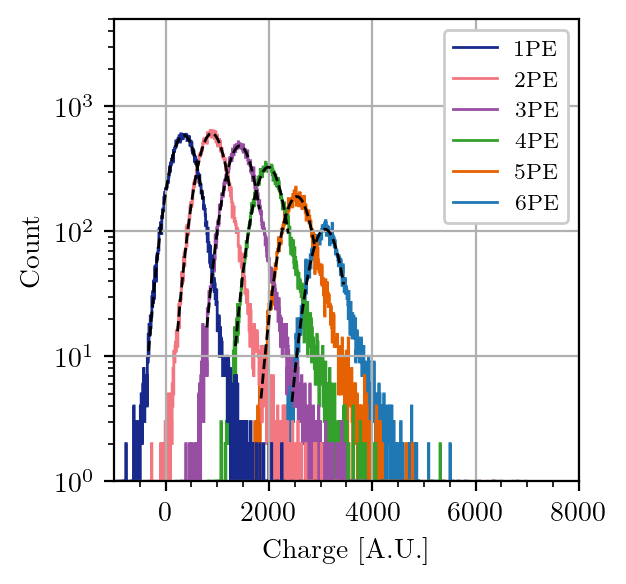

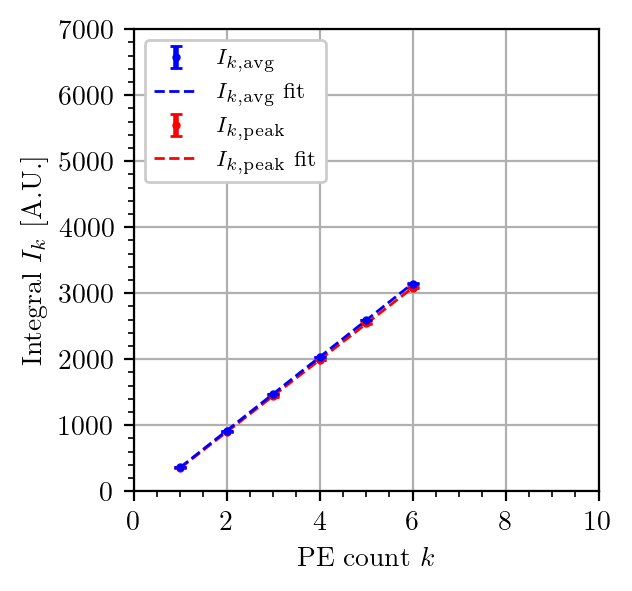

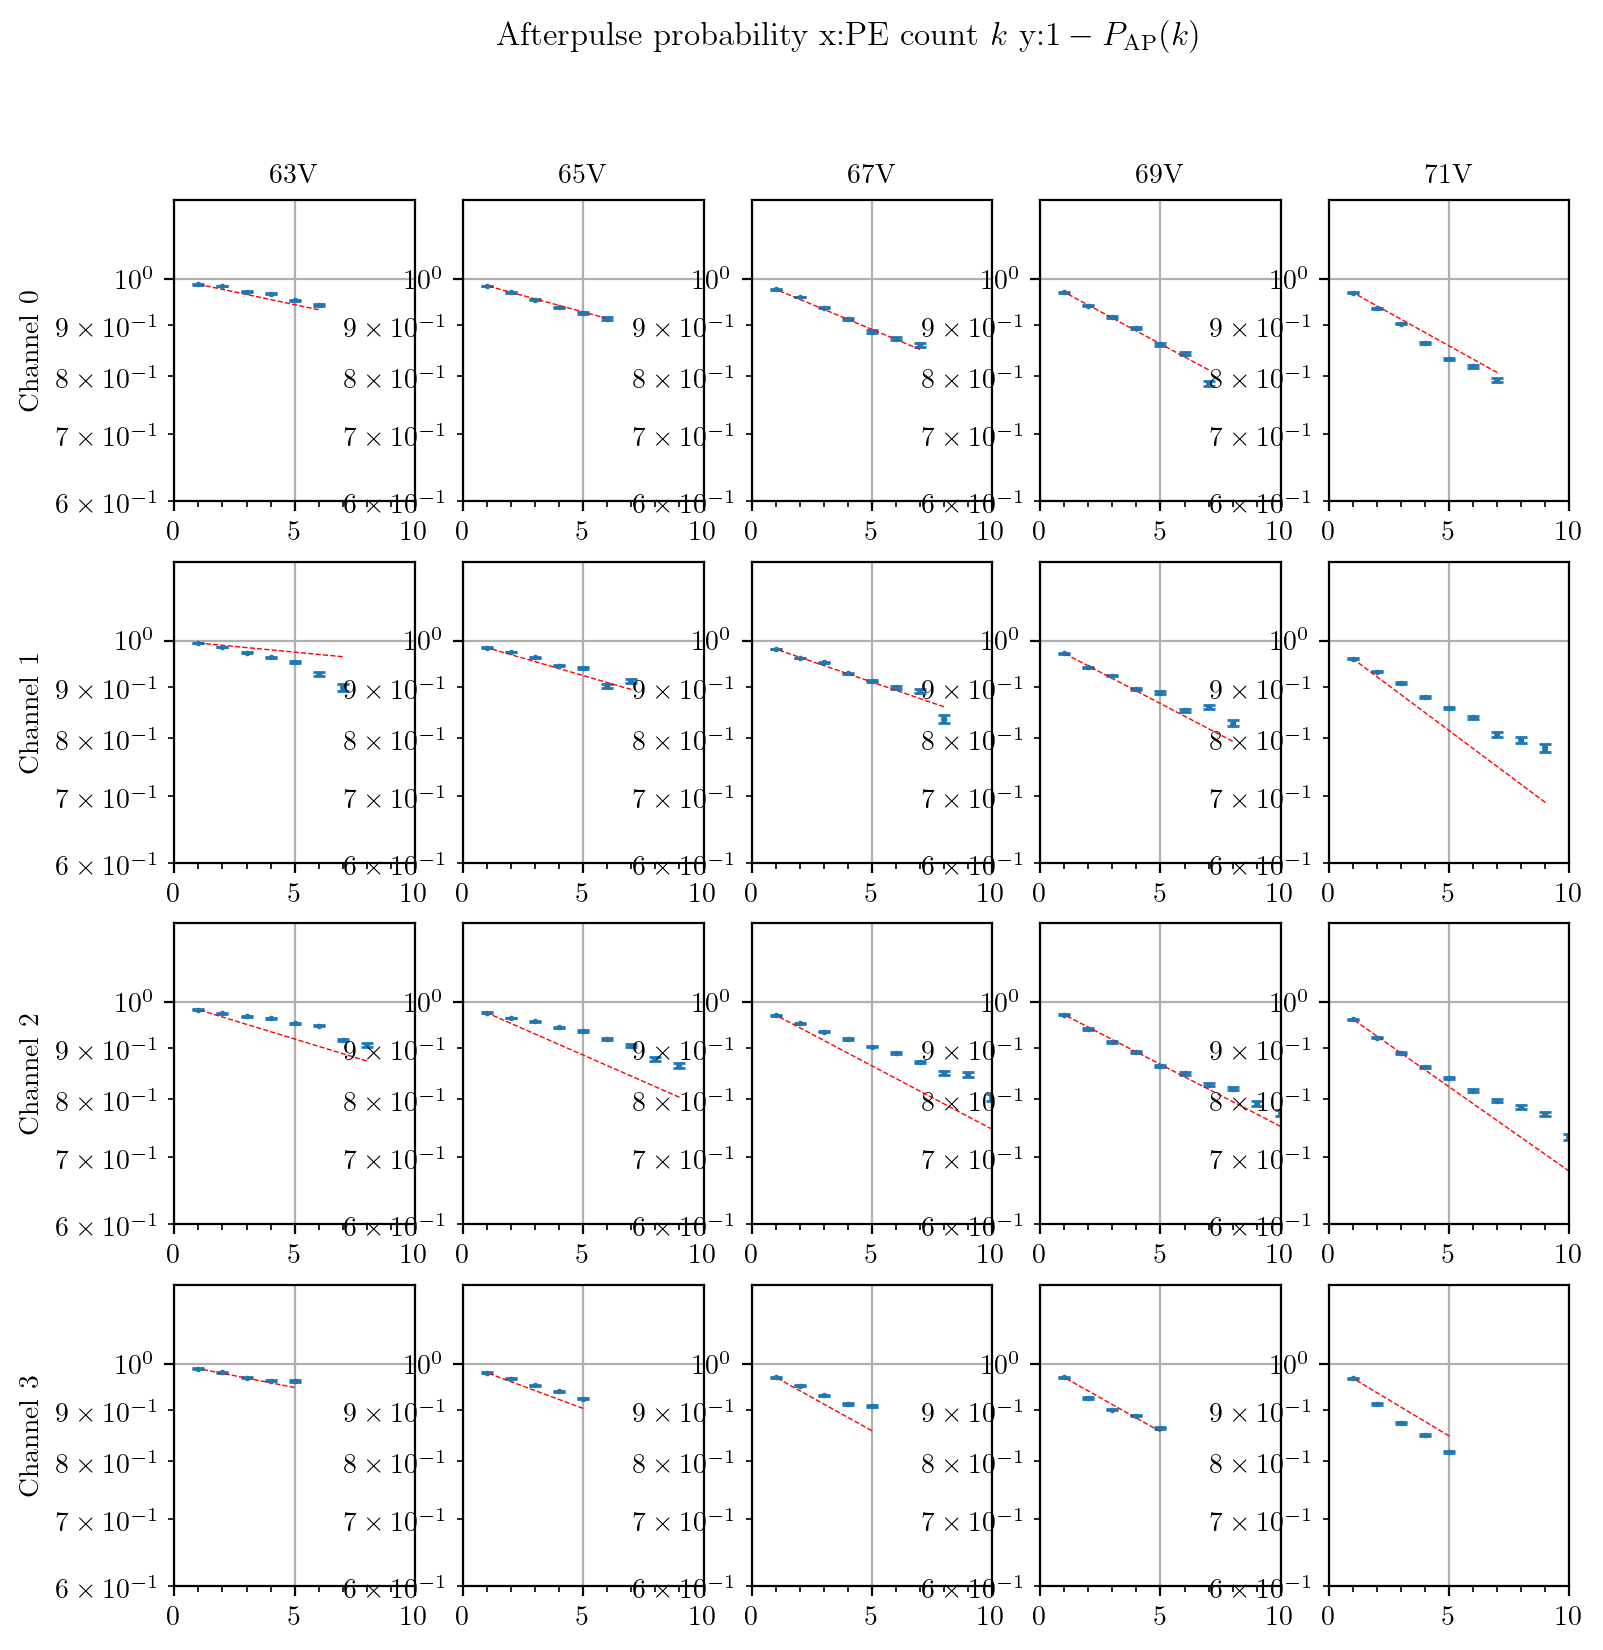

In [12]:
plt.figure(0,figsize=(15,15)) # for charge histograms
plt.suptitle(r'Charge histograms (bottom) x:charge y:count')
plt.figure(1,figsize=(9,9)) # for I_k fits
plt.suptitle(r'Gain fit (bottom) x:PE count ($k$) y:charge ($I_k$)')
plt.figure(2,figsize=(3,3)) # for afterpulse
plt.figure(3,figsize=(9,3)) # for Vbd
plt.suptitle('Breakdown voltage fit (bottom)')
plt.figure(4,figsize=(3,3)) # histogram for one particular channel
plt.figure(5,figsize=(3,3)) # gain-bias fit for one particular channel
plt.figure(6,figsize=(9,9)) # 1-P_ap(k) vs [1-P_ap(1)]^k
Vbd_charge_bot = np.zeros((4,2)) # store breakdown voltage

# choice of channel and voltage for histogram
chn = 0
iv = 1

for ch in range(4):
    for i,data in enumerate(ds1122bot):
        # charge histogram binning
        x_min=-0.1e4
        x_max=5e3+i*2e3
        n_bins=1000
        bin_w = (x_max-x_min)/n_bins
        Ik_peak = [] 
        Ik_avg = []
        counts = []
        counts_noap = []
        # make histogram
        data.ch[ch].get_charge_histo_pe(bin=[x_min, x_max, n_bins])
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.xlim(x_min, x_max)
        plt.ylim(1,5e3)
        plt.yscale('log')
        plt.minorticks_on()
        plt.grid()
        # analyze histogram for each PE count
        maxpe = len(data.ch[ch].ap_charge)-1
        if ch==3:
            maxpe = 5
        for j in np.arange(maxpe,0,-1):
            # Calculate mean and std in the histogram range
            all_charge_nparray = np.array(data.ch[ch].ap_charge[j])
            charge_mean = np.mean(all_charge_nparray, where=np.logical_and(all_charge_nparray>x_min, all_charge_nparray<x_max))
            charge_std = np.std(all_charge_nparray, where=np.logical_and(all_charge_nparray>x_min, all_charge_nparray<x_max))
            charge_count = np.sum(np.logical_and(all_charge_nparray>x_min, all_charge_nparray<x_max))
            counts.append(charge_count)
            Ik_avg.append([charge_mean, charge_std/np.sqrt(charge_count)])
            plt.figure(0)
            plt.stairs(data.ch[ch].ap_charge_hist[j], data.ch[ch].ap_charge_hist_bin[j])
            p = np.argmax(data.ch[ch].ap_charge_hist[j]) # in bins
            fit1 = p
            fit2 = p
            while data.ch[ch].ap_charge_hist[j][fit1]>0.02*data.ch[ch].ap_charge_hist[j][p]:
                fit1 -= 1
            if data.ch[ch].ap_charge_hist[j][fit1]==0:
                fit1 += 1
            while data.ch[ch].ap_charge_hist[j][fit2]>0.3*data.ch[ch].ap_charge_hist[j][p]:
                fit2 += 1
            if data.ch[ch].ap_charge_hist[j][fit2]==0:
                fit2 -= 1
            popt,pcov = curve_fit(func.gauss_normalized, 0.5*(data.ch[ch].ap_charge_hist_bin[j][fit1:fit2]+data.ch[ch].ap_charge_hist_bin[j][fit1+1:fit2+1]), data.ch[ch].ap_charge_hist[j][fit1:fit2], p0=[np.max(data.ch[ch].ap_charge_hist[j])*(fit2-fit1)*bin_w/3,p*bin_w+x_min,(fit2-fit1)*bin_w/3], sigma=np.sqrt(data.ch[ch].ap_charge_hist[j][fit1:fit2]), maxfev=100000)
            plt.plot(data.ch[ch].ap_charge_hist_bin[j][fit1:fit2], func.gauss_normalized(data.ch[ch].ap_charge_hist_bin[j][fit1:fit2], *popt), 'k--', linewidth=1)
            Ik_peak.append([popt[1],func.error_distance(df=3,sigma=1)*np.sqrt(pcov[1,1])])
            counts_noap.append(popt[0]/bin_w)
            if ch==chn and i==iv:
                plt.figure(4)
                plt.stairs(data.ch[ch].ap_charge_hist[j], data.ch[ch].ap_charge_hist_bin[j], label='{}PE'.format(j))
                plt.plot(data.ch[ch].ap_charge_hist_bin[j][fit1:fit2], func.gauss_normalized(data.ch[ch].ap_charge_hist_bin[j][fit1:fit2], *popt), 'k--', linewidth=1)
                plt.legend(loc='upper right')
                plt.minorticks_on()
                plt.grid()
        # plot 1-P_ap(k) and compare with [1-P_ap(1)]^k
        plt.figure(6)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        pe_counts = np.arange(maxpe,0,-1)
        one_m_pap = np.array(counts_noap)/np.array(counts)
        plt.errorbar(pe_counts, one_m_pap, yerr=np.sqrt(one_m_pap*(1-one_m_pap)/np.array(counts)), fmt='o', markersize=1)
        plt.plot(pe_counts, one_m_pap[-1]**pe_counts, 'r--', linewidth=0.5)
        plt.xlim(0, 10)
        plt.ylim(0.6,1.2)
        plt.yscale('log')
        plt.minorticks_on()
        plt.grid()

        # plot mu-pe vs avg-pe
        Ik_peak = list(reversed(Ik_peak))
        Ik_avg = list(reversed(Ik_avg))
        plt.figure(1)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        # Q_peak fit
        plt.errorbar(np.arange(maxpe)+1, np.array(Ik_peak)[:,0], yerr=np.array(Ik_peak)[:,1], fmt='r.', markersize=2, label=r'$I_{k,\rm peak}$')
        popt,pcov=curve_fit(func.line_simple,np.arange(maxpe)+1, np.array(Ik_peak)[:,0], p0=[500,0], sigma=np.array(Ik_peak)[:,1], maxfev=10000)
        data.ch[ch].gain_peak=[popt[0],func.error_distance(df=2,sigma=1)*np.sqrt(pcov[0,0])]
        plt.plot(np.arange(maxpe)+1, func.line_simple(np.arange(maxpe)+1, *popt), 'r--', label=r'$I_{k,\rm peak}$ fit', linewidth=1)
        if ch==chn and i==iv:
            plt.figure(5)
            plt.errorbar(np.arange(maxpe)+1, np.array(Ik_peak)[:,0], yerr=np.array(Ik_peak)[:,1], fmt='ro', markersize=2, label=r'$I_{k,\rm peak}$')
            plt.plot(np.arange(maxpe)+1, func.line_simple(np.arange(maxpe)+1, *popt), 'r--', label=r'$I_{k,\rm peak}$ fit', linewidth=1)
        plt.figure(1)
        # Q_avg fit
        plt.errorbar(np.arange(maxpe)+1, np.array(Ik_avg)[:,0], yerr=np.array(Ik_avg)[:,1], fmt='b.', markersize=2, label=r'$I_{k,\rm avg}$')
        popt_,pcov_=curve_fit(func.line_simple,np.arange(maxpe)+1,np.array(Ik_avg)[:,0], p0=[500,0], sigma=np.array(Ik_avg)[:,1], maxfev=10000)
        data.ch[ch].gain_avg=[popt_[0],func.error_distance(df=2,sigma=1)*np.sqrt(pcov_[0,0])]
        plt.plot(np.arange(maxpe)+1, func.line_simple(np.arange(maxpe)+1, *popt_), 'b--', label=r'$I_{k,\rm avg}$ fit', linewidth=1)
        if ch==chn and i==iv:
            plt.figure(5)
            plt.errorbar(np.arange(maxpe)+1, np.array(Ik_avg)[:,0], yerr=np.array(Ik_avg)[:,1], fmt='bo', markersize=2, label=r'$I_{k,\rm avg}$')
            plt.plot(np.arange(maxpe)+1, func.line_simple(np.arange(maxpe)+1, *popt_), 'b--', label=r'$I_{k,\rm avg}$ fit', linewidth=1)
        plt.figure(1)
        plt.xlim(0,10)
        plt.ylim(0,1.6e4)
        plt.legend()
        plt.grid()
        plt.minorticks_on()
        data.ch[ch].ap=[popt_[0]/popt[0]-1, func.error_distance(df=2,sigma=1)*popt_[0]/popt[0]*np.sqrt(pcov[0,0]/popt[0]**2+pcov_[0,0]/popt_[0]**2)]

    # plot after-pulses
    plt.figure(2)
    plt.errorbar(bias, [data.ch[ch].ap[0] for data in ds1122bot], yerr=[data.ch[ch].ap[1] for data in ds1122bot], label='CH{}'.format(ch), fmt='o', markersize=2)

    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].gain_peak[0] for data in ds1122bot]
    err = [data.ch[ch].gain_peak[1] for data in ds1122bot]
    popt,pcov = curve_fit(func.line, xlin, ylin, sigma=err, p0=[100, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],func.error_distance(df=2,sigma=1)*np.sqrt(pcov[1,1]),popt[0],func.error_distance(df=2,sigma=1)*np.sqrt(pcov[0,0])))
    Vbd_charge_bot[ch,:] = np.array([popt[1],func.error_distance(df=2,sigma=1)*np.sqrt(pcov[1,1])])
    plt.figure(3)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel(r'SPE Gain $Q_{\rm peak}$ [A.U.]')
    plt.xlabel('Bias [V]')
    plt.errorbar(xlin,ylin,yerr=err,fmt='o', markersize=2)
    plt.plot(sorted(xlin+[popt[1]]),func.line(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,1000)
    plt.minorticks_on()
    plt.grid()

plt.figure(2)
plt.legend()
plt.minorticks_on()
plt.grid()
plt.xlabel('Bias Voltage [V]')
plt.ylabel('Afterpulse charge [PE/PE]')
plt.xlim(62,72)
plt.ylim(-0.01, 0.1)

plt.figure(4)
plt.yscale('log')
#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = np.arange(len(labels)-1, -1, -1)
#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='upper right')
plt.minorticks_on()
plt.grid()
plt.ylim(1e0, 5e3)
plt.xlim(x_min, 6e3+2e3*iv)
plt.xlabel('Charge [A.U.]')
plt.ylabel('Count')

plt.figure(5)
plt.xlabel(r'PE count $k$')
plt.ylabel(r'Integral $I_k$ [A.U.]')
plt.xlim(0,10)
plt.ylim(0,7e3)
#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = [3,1,2,0]
#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='upper left')
plt.minorticks_on()
plt.grid()

plt.figure(6)
plt.suptitle(r'Afterpulse probability x:PE count $k$ y:$1-P_{\rm AP}(k)$')

## DiCT summary

(0.0, 0.6)

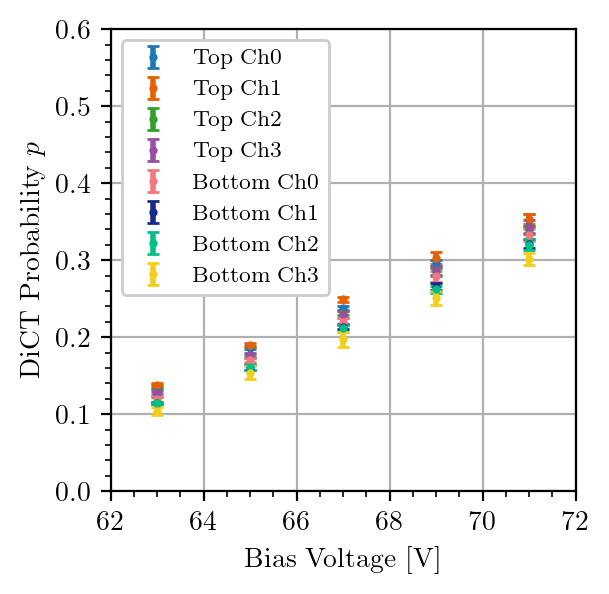

In [13]:
plt.figure(0,figsize=(3,3))
for ch in range(4):
    plt.errorbar(bias, [dset.ch[ch].dict[0] for dset in ds1122top], yerr=[dset.ch[ch].dict[1] for dset in ds1122top], label='Top Ch{}'.format(ch), fmt='o', markersize=2)
for ch in range(4):
    plt.errorbar(bias, [dset.ch[ch].dict[0] for dset in ds1122bot], yerr=[dset.ch[ch].dict[1] for dset in ds1122bot], label='Bottom Ch{}'.format(ch), fmt='o', markersize=2)
plt.legend()
plt.xlabel('Bias Voltage [V]')
plt.ylabel(r'DiCT Probability $p$')
plt.grid()
plt.minorticks_on()
plt.xlim(62,72)
plt.ylim(0, 0.6)

# AP Summary

(0.0, 0.1)

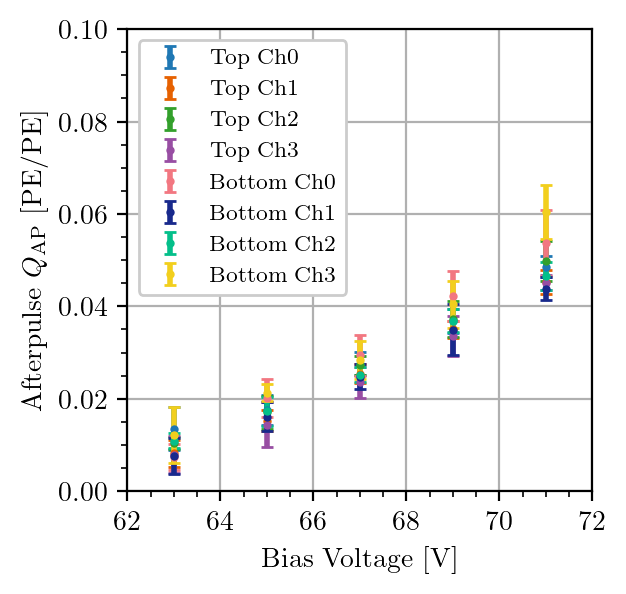

In [14]:
plt.figure(0,figsize=(3,3))
for ch in range(4):
    plt.errorbar(bias, [dset.ch[ch].ap[0] for dset in ds1122top], yerr=[dset.ch[ch].ap[1] for dset in ds1122top], label='Top Ch{}'.format(ch), fmt='o', markersize=2)
for ch in range(4):
    plt.errorbar(bias, [dset.ch[ch].ap[0] for dset in ds1122bot], yerr=[dset.ch[ch].ap[1] for dset in ds1122bot], label='Bottom Ch{}'.format(ch), fmt='o', markersize=2)
plt.legend()
plt.xlabel('Bias Voltage [V]')
plt.ylabel(r'Afterpulse $Q_{\rm AP}$ [PE/PE]')
plt.grid()
plt.minorticks_on()
plt.xlim(62,72)
plt.ylim(0, 0.1)

## Breakdown Voltage Summary

Top ch0 Vbd=53.773+/-0.442V slope=48.791+/-1.603
Top ch1 Vbd=53.342+/-0.168V slope=46.890+/-0.603
Top ch2 Vbd=53.733+/-0.263V slope=47.440+/-1.134
Top ch3 Vbd=53.027+/-0.709V slope=44.376+/-2.078
Bottom ch0 Vbd=54.408+/-0.197V slope=51.511+/-0.959
Bottom ch1 Vbd=53.702+/-0.564V slope=44.532+/-1.908
Bottom ch2 Vbd=53.931+/-0.299V slope=48.156+/-1.255
Bottom ch3 Vbd=53.786+/-0.451V slope=48.247+/-1.797


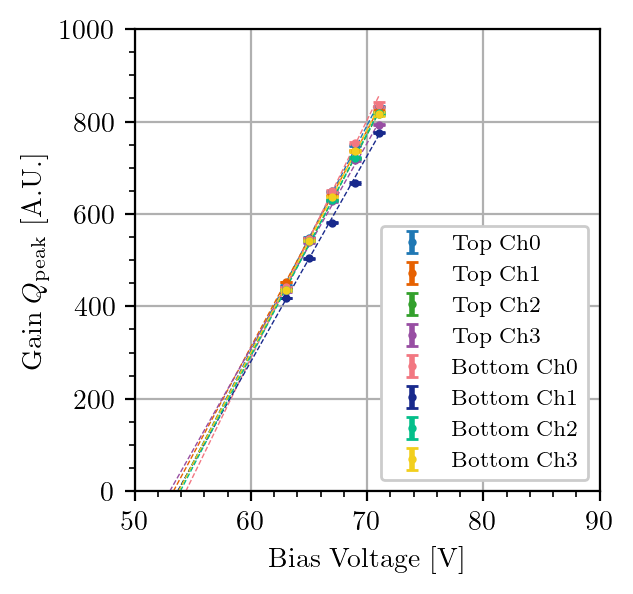

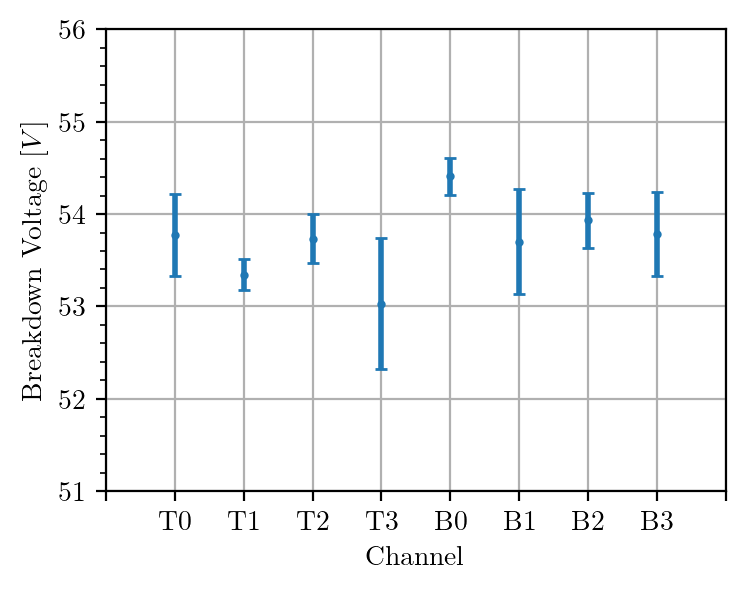

Breakdown voltage per SiPM = 26.89+/-0.05(stat) V
RMS variation = 0.20V


In [15]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

plt.figure(0,figsize=(3,3))
for ch in range(4):
    xlin = bias
    ylin = [data.ch[ch].gain_peak[0] for data in ds1122top]
    err = [data.ch[ch].gain_peak[1] for data in ds1122top]
    popt,pcov = curve_fit(func.line, xlin, ylin, sigma=err, p0=[100, 55], maxfev=10000)
    print("Top ch{} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],func.error_distance(df=2,sigma=1)*np.sqrt(pcov[1,1]),popt[0],func.error_distance(df=2,sigma=1)*np.sqrt(pcov[0,0])))
    plt.errorbar(xlin, ylin, yerr=err, label='Top Ch{}'.format(ch), fmt='C{}o'.format(ch), markersize=2)
    plt.plot(sorted(xlin+[popt[1]]),func.line(np.array(sorted(xlin+[popt[1]])),*popt),'C{}--'.format(ch), linewidth=0.5)

for ch in range(4):
    xlin = bias
    ylin = [data.ch[ch].gain_peak[0] for data in ds1122bot]
    err = [data.ch[ch].gain_peak[1] for data in ds1122bot]
    popt,pcov = curve_fit(func.line, xlin, ylin, sigma=err, p0=[100, 55], maxfev=10000)
    print("Bottom ch{} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],func.error_distance(df=2,sigma=1)*np.sqrt(pcov[1,1]),popt[0],func.error_distance(df=2,sigma=1)*np.sqrt(pcov[0,0])))
    plt.errorbar(xlin, ylin, yerr=err, label='Bottom Ch{}'.format(ch), fmt='C{}o'.format(ch+4), markersize=2)
    plt.plot(sorted(xlin+[popt[1]]),func.line(np.array(sorted(xlin+[popt[1]])),*popt),'C{}--'.format(ch+4), linewidth=0.5)

plt.legend(loc='lower right')
plt.xlabel('Bias Voltage [V]')
plt.ylabel(r'Gain $Q_{\rm peak}$ [A.U.]')
plt.grid()
plt.minorticks_on()
plt.xlim(50,90)
plt.ylim(0, 1.0e3)

fig, ax = plt.subplots()
vbd_ch = np.concatenate((Vbd_charge_top, Vbd_charge_bot))
plt.errorbar(np.arange(8), vbd_ch[:,0], yerr=vbd_ch[:,1], fmt='o', markersize=2)
plt.xlabel('Channel')
plt.ylabel(r'Breakdown Voltage [$V$]')
ax.set_xticklabels(['', '', 'T0', 'T1','T2','T3','B0','B1','B2','B3'])
plt.xlim(-1,8)
plt.ylim(51,56)
plt.grid()
plt.minorticks_on()
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_tick_params(which='minor', bottom=False)
plt.show()

vbd_avg = np.average(vbd_ch[:,0], weights=1/vbd_ch[:,1]**2)/2
vbd_stat = np.sum(1/vbd_ch[:,1]**2)**(-0.5)/2
print('Breakdown voltage per SiPM = {:.2f}+/-{:.2f}(stat) V'.format(vbd_avg,vbd_stat))
vbd_rms = np.std(vbd_ch[:,0],ddof=1)/2
print('RMS variation = {:.2f}V'.format(vbd_rms))

## Write to csv file

In [16]:
import csv
for i,v in enumerate(bias):
    with open('data/calibration/calibration_1122_{}V.csv'.format(v), 'w') as f:
        w = csv.writer(f)
        w.writerow(['CH', 'A1min', 'A1max', 'p', 'p_err', 'Qavg', 'Qavg_err', 'Qpeak', 'Qpeak_err', 'Qap', 'Qap_err'])
        for ch in range(4):
            dset = ds1122top[i].ch[ch]
            row = ['T{}'.format(ch)]
            row += [str(dset.pe_cuts[1]), str(dset.pe_cuts[2])]
            row += [str(dset.dict[0]), str(dset.dict[1])]
            row += [str(dset.gain_avg[0]), str(dset.gain_avg[1])]
            row += [str(dset.gain_peak[0]), str(dset.gain_peak[1])]
            row += [str(dset.ap[0]), str(dset.ap[1])]
            w.writerow(row)
        for ch in range(4):
            dset = ds1122bot[i].ch[ch]
            row = ['B{}'.format(ch)]
            row += [str(dset.pe_cuts[1]), str(dset.pe_cuts[2])]
            row += [str(dset.dict[0]), str(dset.dict[1])]
            row += [str(dset.gain_avg[0]), str(dset.gain_avg[1])]
            row += [str(dset.gain_peak[0]), str(dset.gain_peak[1])]
            row += [str(dset.ap[0]), str(dset.ap[1])]
            w.writerow(row)

## Calculate $\frac{1+p}{PDE}$ versus over-voltage
Read PDE data

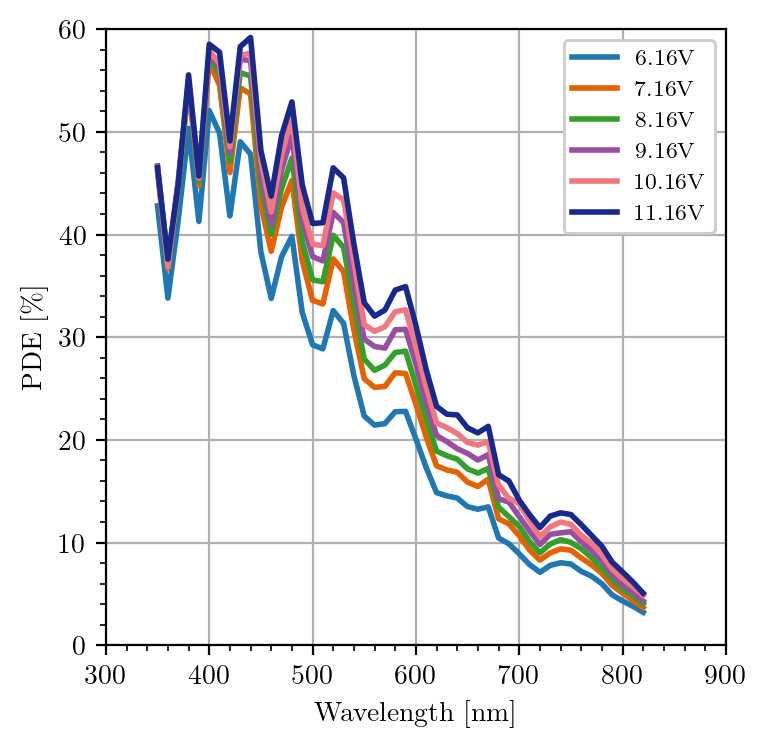

In [17]:
import ROOT
from scipy.interpolate import interp1d

plt.figure(0,figsize=(4,4))
vov = [6.16,7.16,8.16,9.16,10.16,11.16]
pde_curves = []
for v in vov:
    pde_curves.append({'wavelength':[],'pde':[]})
    with open('data/sipm/PDE_{}V.csv'.format(v)) as f:
        r = csv.reader(f)
        header = next(r)
        for row in r:
            if(len(row)==0):
                break
            pde_curves[-1]['wavelength'].append(float(row[0]))
            pde_curves[-1]['pde'].append(float(row[1]))
    plt.plot(np.array(pde_curves[-1]['wavelength']), np.array(pde_curves[-1]['pde']), label='{:.2f}V'.format(v))
plt.legend(loc='upper right')
plt.minorticks_on()
plt.grid()
plt.xlabel('Wavelength [nm]')
plt.ylabel('PDE [\%]')

pde_volt = []
for i in range(len(vov)):
    pde_volt.append(interp1d(np.array(pde_curves[i]['wavelength']), np.array(pde_curves[i]['pde'])))

pde420nm = interp1d( np.array(vov), np.array( [pde_volt[i](420)/100 for i in range(len(vov))] ) )

Get average DiCT $p$ and then compute enf

Text(0, 0.5, 'ENF')

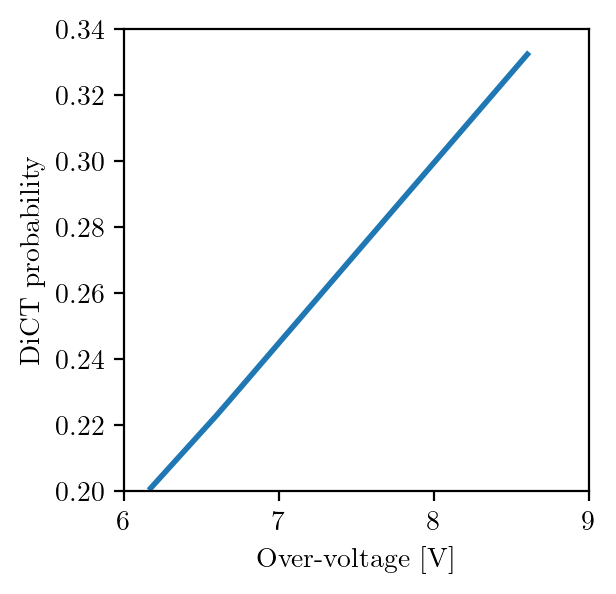

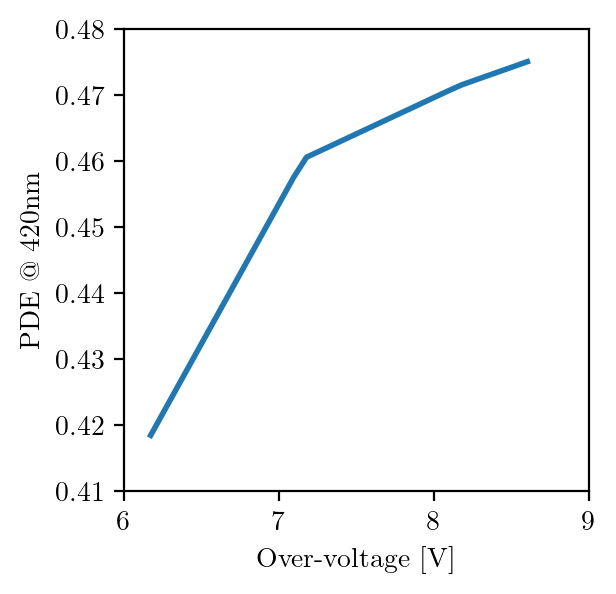

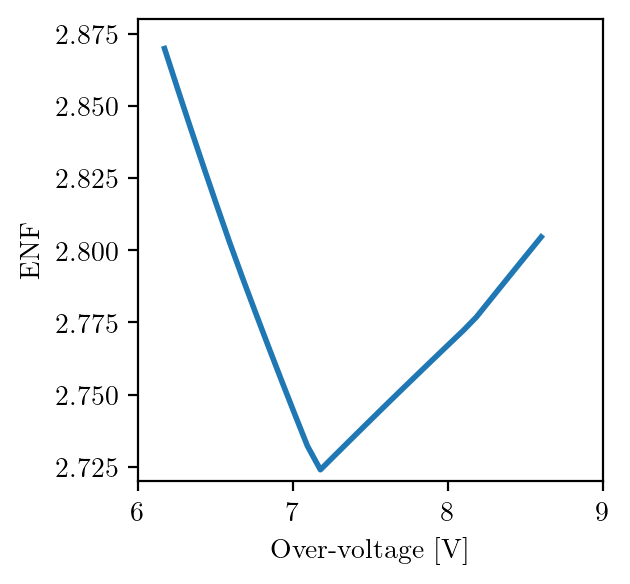

In [18]:
dict_avg = [np.mean(np.array([ds1122top[iv].ch[ch].dict[0] for ch in range(4)] + [ds1122bot[iv].ch[ch].dict[0] for ch in range(4)])) for iv in range(5)]
ov = np.array(bias)/2 - vbd_avg
dict_ov = interp1d(ov, dict_avg)

ov_plot = np.linspace(6.17, 8.6, 30)
plt.figure(0,figsize=(3,3))
plt.plot(ov_plot,dict_ov(ov_plot))
plt.xlabel('Over-voltage [V]')
plt.ylabel('DiCT probability')
plt.figure(1,figsize=(3,3))
plt.plot(ov_plot, pde420nm(ov_plot))
plt.xlabel('Over-voltage [V]')
plt.ylabel('PDE @ 420nm')
plt.figure(2,figsize=(3,3))
plt.plot(ov_plot, (1+dict_ov(ov_plot))/pde420nm(ov_plot))
plt.xlabel('Over-voltage [V]')
plt.ylabel('ENF')